# 2. Основная часть
### Импорт библиотек:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Загрузка и первичный анализ данных
### Текстовое описание набора данных:
В качестве набора данных использован набор данных по прогнозированию мошеннических транзакций - [IEEE-CIS Fraud Detection](https://www.kaggle.com/c/ieee-fraud-detection/).

Датасет состоит из четырех файлов:
- **train_{transaction, identity}.csv** - обучающая выборка
- **test_{transaction, identity}.csv** - тестовая выборка

Файлы **{train, test}_transaction.csv** и **{train, test}_identity.csv** соединены между собой полем **TransactionID**.

Колонка **isFraud** является целевым признаком, обозначающим, является ли данная транзакция мошеннической. Принимает значения 1 или 0.

Набор данных содержит следующие категориальные признаки:
- **ProductCD**
- **card1 - card6**
- **addr1, addr2**
- **P_emaildomain**
- **R_emaildomain**
- **M1 - M9**
- **DeviceType**
- **DeviceInfo**
- **id_12 - id_38**

Колонка **TransactionDT** содержит разницу во времени между транзакцией и заданной эталонной датой и временем.

Будем решать задачу бинарной классификации целевого признака в колонке **isFraud**.

### Загрузка данных:

In [2]:
# Будем использовать только обучающую выборку
data = pd.merge(pd.read_csv('E:/train_transaction.csv', sep=","), 
                pd.read_csv('E:/train_identity.csv', sep=","), 
                on='TransactionID', how='left')
# Удаляем колонки с уникальными ID и временем каждой транзакции, т.к.
# они не понадабятся при построении моделей машинного обучения
data.drop(columns=['TransactionID', 'TransactionDT'], inplace=True)

## Разведочный анализ данных

### Основные характеристики датасета:

In [3]:
# Первые 5 строк датасета
data.head()

,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,0,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [4]:
# Размер датасета: (кол-во строк, кол-во колонок)
data.shape

(590540, 432)

In [5]:
# Список колонок с типами данных
data.dtypes

isFraud             int64
TransactionAmt    float64
ProductCD          object
card1               int64
card2             float64
                   ...   
id_36              object
id_37              object
id_38              object
DeviceType         object
DeviceInfo         object
Length: 432, dtype: object

In [6]:
# Список колонок с количеством пропущенных значений
data.isnull().sum()

isFraud                0
TransactionAmt         0
ProductCD              0
card1                  0
card2               8933
                   ...  
id_36             449555
id_37             449555
id_38             449555
DeviceType        449730
DeviceInfo        471874
Length: 432, dtype: int64

In [7]:
# Общее количество пропущенных значений
data.isnull().sum().sum()

115523073

**Вывод.** Данный набор данных содержит пропуски в обучающей выборке, следовательно, нуждается в обработке пропусков в данных.

In [8]:
# Основные статистические характеристики набора данных
data.describe()

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,...,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,590540.000000,590540.000000,590540.000000,581607.000000,588975.000000,586281.000000,524834.000000,524834.000000,238269.000000,37627.000000,...,139369.000000,45113.000000,139318.000000,139261.000000,5159.000000,5169.000000,4747.000000,5132.000000,5163.000000,77586.000000
mean,0.034990,135.027176,9898.734658,362.555488,153.194925,199.278897,290.733794,86.800630,118.502180,231.855423,...,189.451377,14.237337,353.128174,403.882666,368.269820,16.002708,12.800927,329.608924,149.070308,26.508597
std,0.183755,239.162522,4901.170153,157.793246,11.336444,41.244453,101.741072,2.690623,371.872026,529.053494,...,30.375360,1.561302,141.095343,152.160327,198.847038,6.897665,2.372447,97.461089,32.101995,3.737502
min,0.000000,0.251000,1000.000000,100.000000,100.000000,100.000000,100.000000,10.000000,0.000000,0.000000,...,100.000000,10.000000,100.000000,100.000000,100.000000,10.000000,11.000000,100.000000,100.000000,0.000000
25%,0.000000,43.321000,6019.000000,214.000000,150.000000,166.000000,204.000000,87.000000,3.000000,7.000000,...,166.000000,13.000000,266.000000,256.000000,252.000000,14.000000,11.000000,321.000000,119.000000,24.000000
50%,0.000000,68.769000,9678.000000,361.000000,150.000000,226.000000,299.000000,87.000000,8.000000,37.000000,...,166.000000,15.000000,341.000000,472.000000,252.000000,14.000000,11.000000,321.000000,149.000000,24.000000
75%,0.000000,125.000000,14184.000000,512.000000,150.000000,226.000000,330.000000,87.000000,24.000000,206.000000,...,225.000000,15.000000,427.000000,533.000000,486.500000,14.000000,15.000000,371.000000,169.000000,32.000000
max,1.000000,31937.391000,18396.000000,600.000000,231.000000,237.000000,540.000000,102.000000,10286.000000,11623.000000,...,229.000000,29.000000,671.000000,661.000000,854.000000,44.000000,26.000000,548.000000,216.000000,32.000000


### Построение графиков для понимания структуры данных

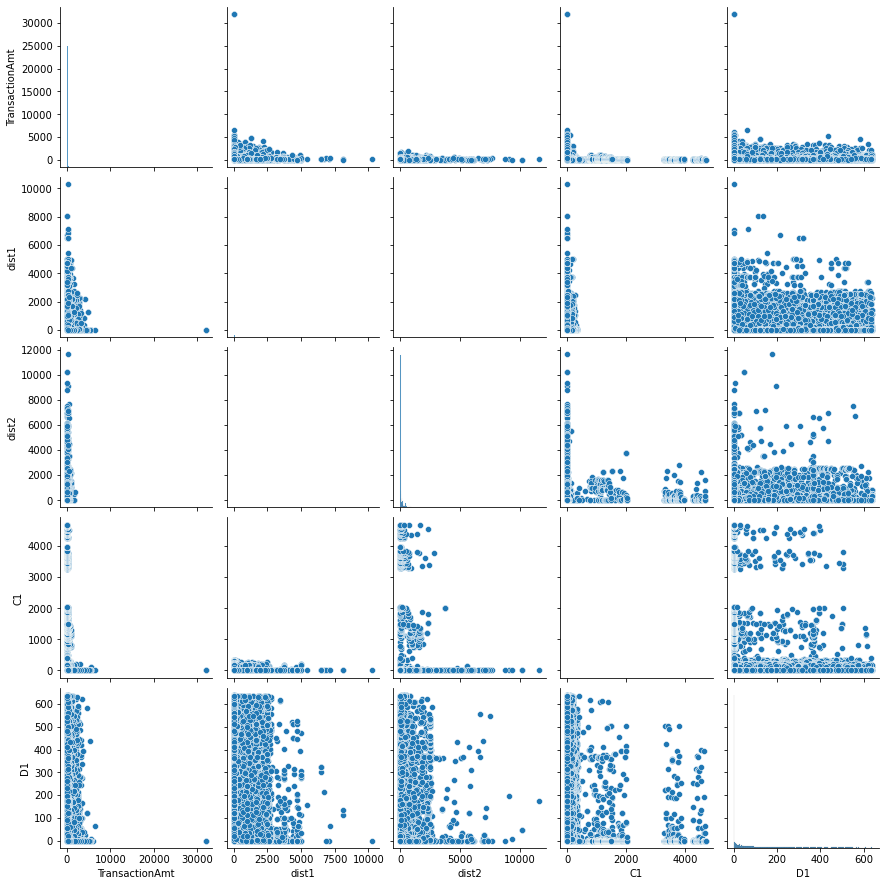

In [9]:
# Парные диаграммы некоторых численных признаков набора данных
sns.pairplot(data[['TransactionAmt', 'dist1', 'dist2', 'C1', 'D1']])

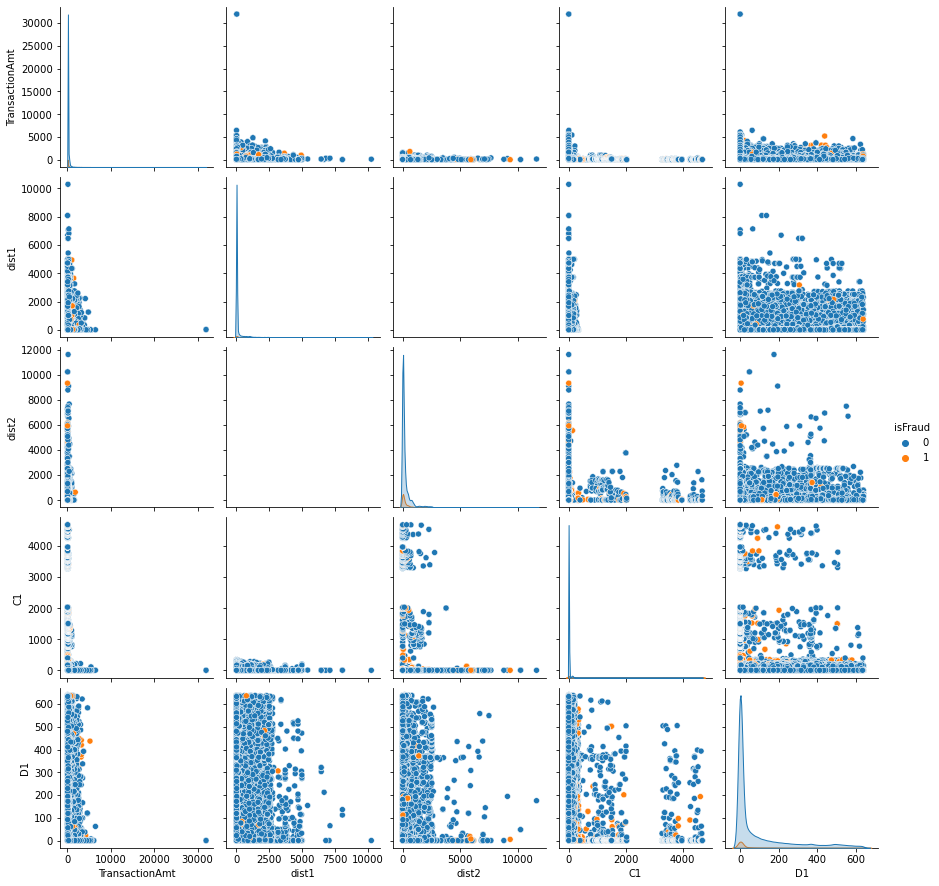

In [10]:
sns.pairplot(data[['isFraud', 'TransactionAmt', 'dist1', 'dist2', 'C1', 'D1']], 
             hue='isFraud')

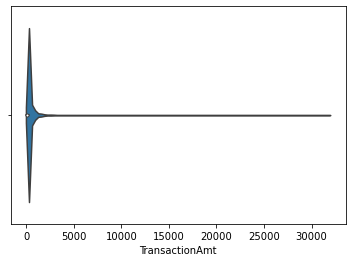

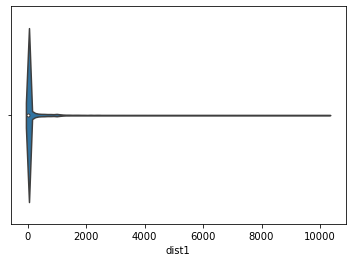

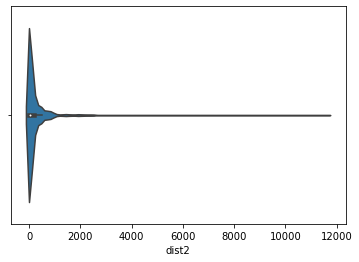

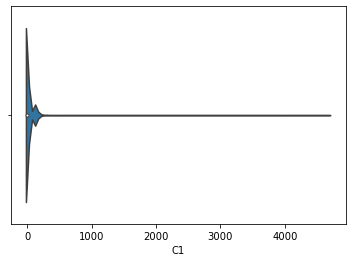

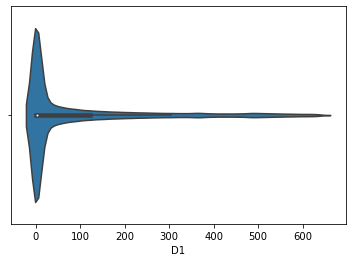

In [11]:
# Скрипичные диаграммы для числовых колонок
for col in ['TransactionAmt', 'dist1', 'dist2', 'C1', 'D1']:
    sns.violinplot(x=data[col])
    plt.show()

In [12]:
# Убедимся, что целевой признак
# для задачи бинарной классификации содержит только 0 и 1
data['isFraud'].unique()

array([0, 1], dtype=int64)

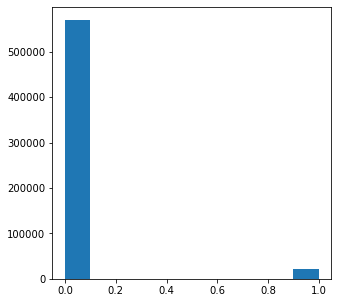

In [13]:
# Оценим дисбаланс классов для isFraud
fig, ax = plt.subplots(figsize=(5,5)) 
plt.hist(data['isFraud'])
plt.show()

In [14]:
# Общее количество машеннических и обычных транзакций в датасете
data['isFraud'].value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

In [15]:
# посчитаем дисбаланс классов
total = data.shape[0]
class_0, class_1 = data['isFraud'].value_counts()
print('Класс 0 составляет {}%, а класс 1 составляет {}%.'
      .format(round(class_0 / total, 4)*100, round((class_1 / total)*100, 4)))

Класс 0 составляет 96.5%, а класс 1 составляет 3.499%.


**Вывод.** В данном наборе данных у целевого признака присутствует сильный дисбаланс классов.

## Обработка пропусков в данных

### Обработка пропусков в числовых данных:

In [16]:
# Выберем числовые колонки с пропущенными значениями
total_count = data.shape[0]
num_cols = []
num_cols_null = []
drop_num_cols = []
# Категориальные признаки
cat_cols = ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 
            'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 
            'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 
            'DeviceType', 'DeviceInfo', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 
            'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 
            'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 
            'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']
# Цикл по колонкам датасета
for col in data.columns:
    if col not in cat_cols:
        num_cols.append(col)
        # Количество пустых значений 
        temp_null_count = data[data[col].isnull()].shape[0]
        dt = str(data[col].dtype)
        if temp_null_count > 0:
            num_cols_null.append(col)
            temp_perc = round((temp_null_count / total_count) * 100.0, 2)
            print('Колонка {}. Тип данных {}. Количество пустых значений {}, {}%.'.format(col, dt, temp_null_count, temp_perc))

Колонка dist1. Тип данных float64. Количество пустых значений 352271, 59.65%.
Колонка dist2. Тип данных float64. Количество пустых значений 552913, 93.63%.
Колонка D1. Тип данных float64. Количество пустых значений 1269, 0.21%.
Колонка D2. Тип данных float64. Количество пустых значений 280797, 47.55%.
Колонка D3. Тип данных float64. Количество пустых значений 262878, 44.51%.
Колонка D4. Тип данных float64. Количество пустых значений 168922, 28.6%.
Колонка D5. Тип данных float64. Количество пустых значений 309841, 52.47%.
Колонка D6. Тип данных float64. Количество пустых значений 517353, 87.61%.
Колонка D7. Тип данных float64. Количество пустых значений 551623, 93.41%.
Колонка D8. Тип данных float64. Количество пустых значений 515614, 87.31%.
Колонка D9. Тип данных float64. Количество пустых значений 515614, 87.31%.
Колонка D10. Тип данных float64. Количество пустых значений 76022, 12.87%.
Колонка D11. Тип данных float64. Количество пустых значений 279287, 47.29%.
Колонка D12. Тип данны

Колонка V94. Тип данных float64. Количество пустых значений 89164, 15.1%.
Колонка V95. Тип данных float64. Количество пустых значений 314, 0.05%.
Колонка V96. Тип данных float64. Количество пустых значений 314, 0.05%.
Колонка V97. Тип данных float64. Количество пустых значений 314, 0.05%.
Колонка V98. Тип данных float64. Количество пустых значений 314, 0.05%.
Колонка V99. Тип данных float64. Количество пустых значений 314, 0.05%.
Колонка V100. Тип данных float64. Количество пустых значений 314, 0.05%.
Колонка V101. Тип данных float64. Количество пустых значений 314, 0.05%.
Колонка V102. Тип данных float64. Количество пустых значений 314, 0.05%.
Колонка V103. Тип данных float64. Количество пустых значений 314, 0.05%.
Колонка V104. Тип данных float64. Количество пустых значений 314, 0.05%.
Колонка V105. Тип данных float64. Количество пустых значений 314, 0.05%.
Колонка V106. Тип данных float64. Количество пустых значений 314, 0.05%.
Колонка V107. Тип данных float64. Количество пустых зна

Колонка V203. Тип данных float64. Количество пустых значений 450909, 76.36%.
Колонка V204. Тип данных float64. Количество пустых значений 450909, 76.36%.
Колонка V205. Тип данных float64. Количество пустых значений 450909, 76.36%.
Колонка V206. Тип данных float64. Количество пустых значений 450909, 76.36%.
Колонка V207. Тип данных float64. Количество пустых значений 450909, 76.36%.
Колонка V208. Тип данных float64. Количество пустых значений 450721, 76.32%.
Колонка V209. Тип данных float64. Количество пустых значений 450721, 76.32%.
Колонка V210. Тип данных float64. Количество пустых значений 450721, 76.32%.
Колонка V211. Тип данных float64. Количество пустых значений 450909, 76.36%.
Колонка V212. Тип данных float64. Количество пустых значений 450909, 76.36%.
Колонка V213. Тип данных float64. Количество пустых значений 450909, 76.36%.
Колонка V214. Тип данных float64. Количество пустых значений 450909, 76.36%.
Колонка V215. Тип данных float64. Количество пустых значений 450909, 76.36%.

Колонка V322. Тип данных float64. Количество пустых значений 508189, 86.05%.
Колонка V323. Тип данных float64. Количество пустых значений 508189, 86.05%.
Колонка V324. Тип данных float64. Количество пустых значений 508189, 86.05%.
Колонка V325. Тип данных float64. Количество пустых значений 508189, 86.05%.
Колонка V326. Тип данных float64. Количество пустых значений 508189, 86.05%.
Колонка V327. Тип данных float64. Количество пустых значений 508189, 86.05%.
Колонка V328. Тип данных float64. Количество пустых значений 508189, 86.05%.
Колонка V329. Тип данных float64. Количество пустых значений 508189, 86.05%.
Колонка V330. Тип данных float64. Количество пустых значений 508189, 86.05%.
Колонка V331. Тип данных float64. Количество пустых значений 508189, 86.05%.
Колонка V332. Тип данных float64. Количество пустых значений 508189, 86.05%.
Колонка V333. Тип данных float64. Количество пустых значений 508189, 86.05%.
Колонка V334. Тип данных float64. Количество пустых значений 508189, 86.05%.

In [17]:
# Выбор числовых колонок, 
# у которых количество пропущенных значений превышает 16%
for col in num_cols_null:
    temp_null_count = data[data[col].isnull()].shape[0]
    temp_perc = round((temp_null_count / total_count) * 100.0, 2)
    if temp_perc >= 16:
        drop_num_cols.append(col)

In [18]:
# Количество числовых колонок с пропущенными значениями и колонок,
# где процент пропущенных значений превышает 16%
(len(num_cols_null), len(drop_num_cols))

(367, 213)

In [19]:
# Удаление числовых колонок, где процент пропущенных значений превышает 16%
data.drop(columns=drop_num_cols, inplace=True)
# Получившийся размер датасета
data.shape

(590540, 219)

In [20]:
for item in drop_num_cols:
    num_cols.remove(item)
    num_cols_null.remove(item)
print('Количество оставшихся необработанных числовых колонок: {}'.format(len(num_cols)))

Количество оставшихся необработанных числовых колонок: 170


### Импьютация (внедрение значений) в числовых данных:

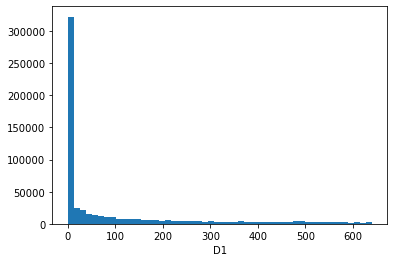

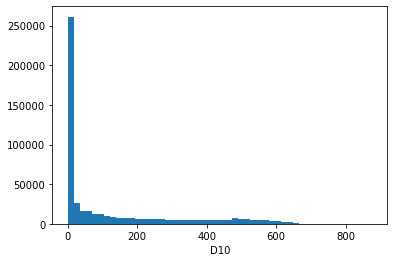

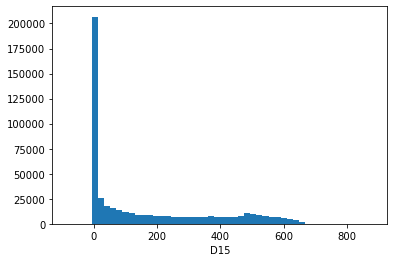

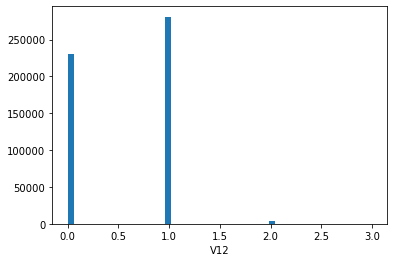

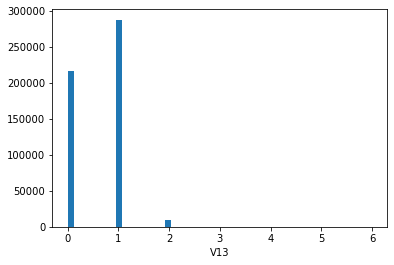

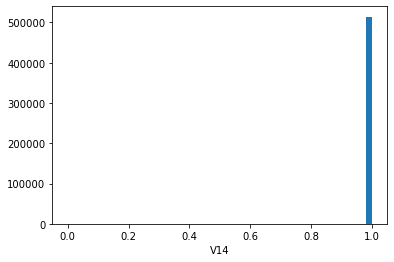

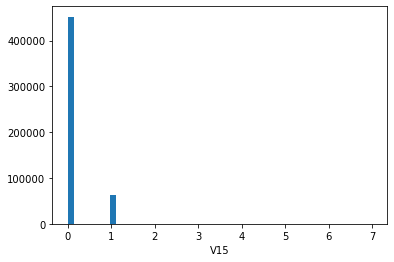

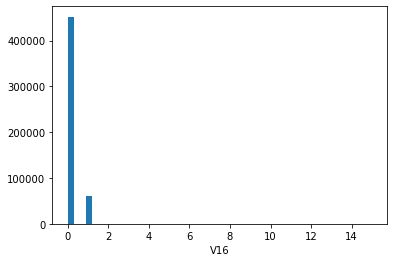

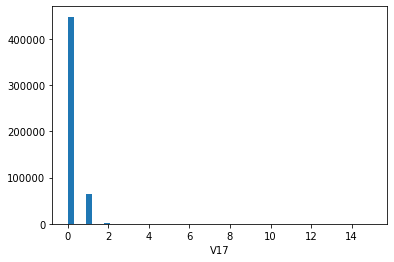

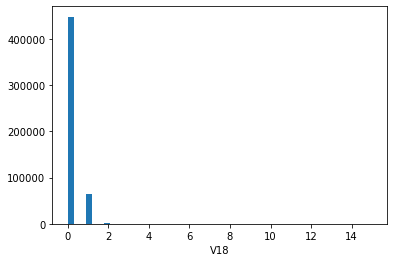

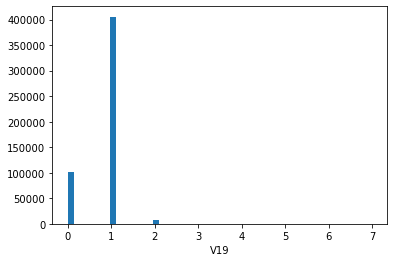

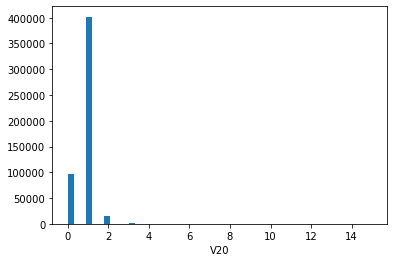

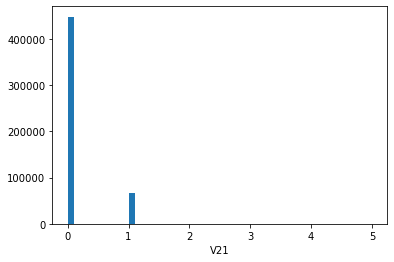

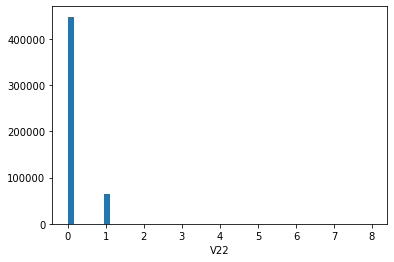

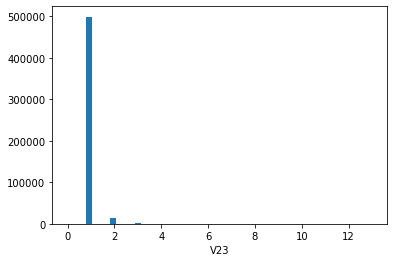

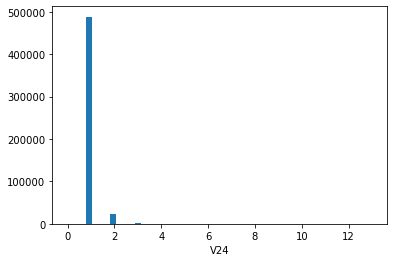

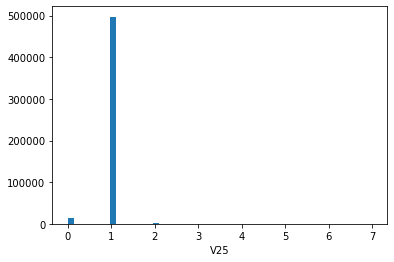

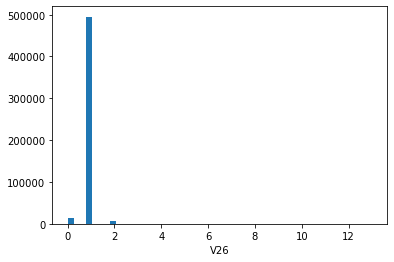

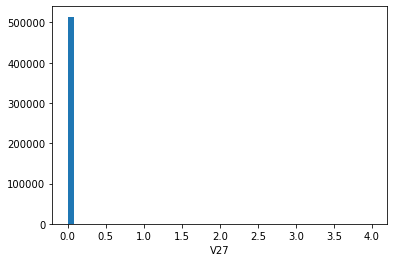

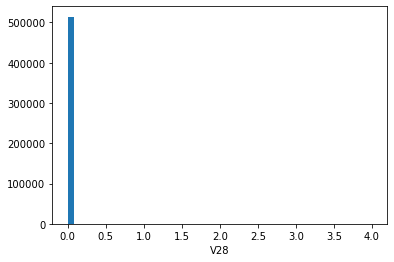

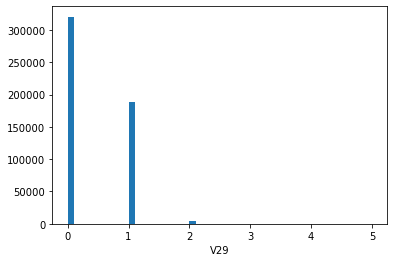

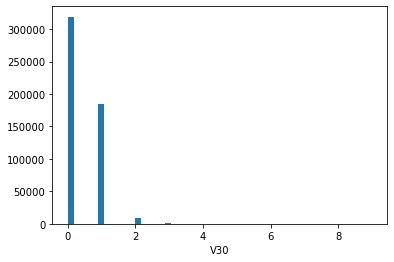

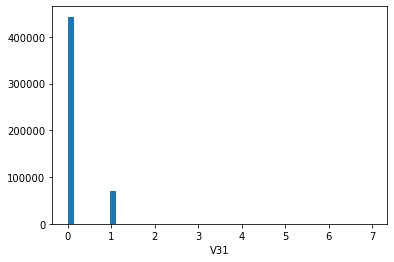

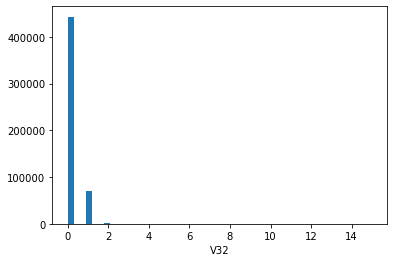

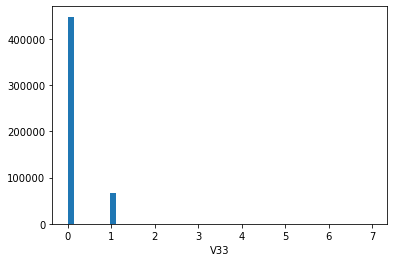

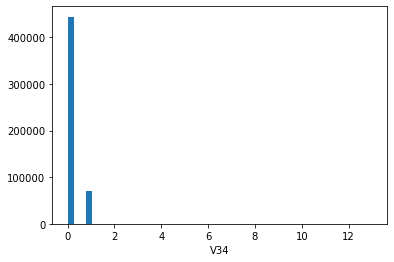

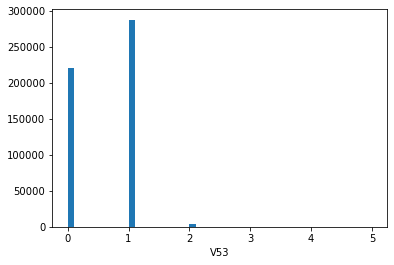

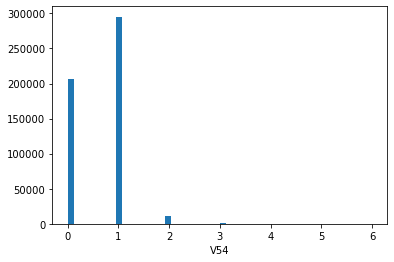

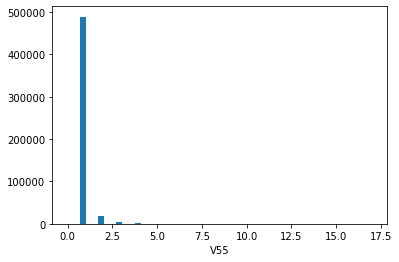

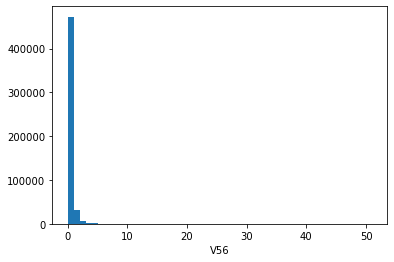

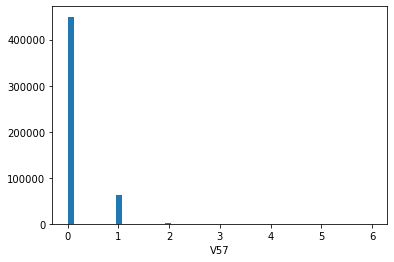

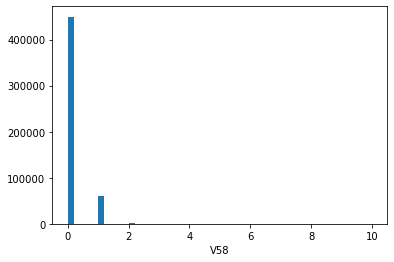

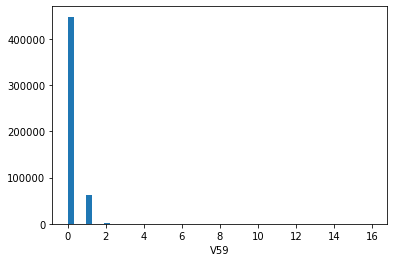

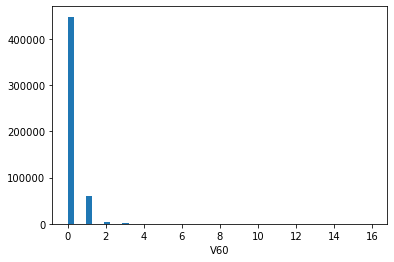

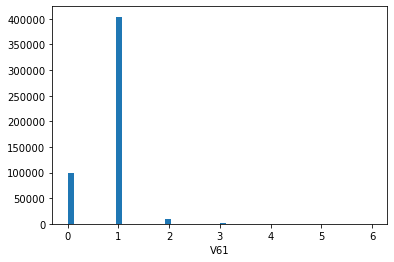

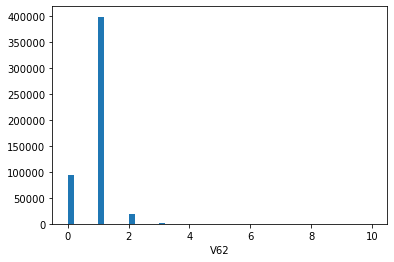

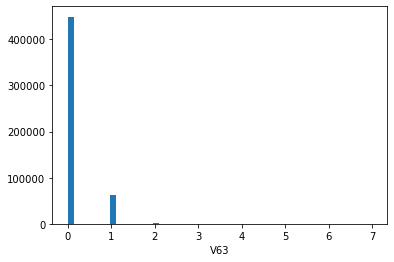

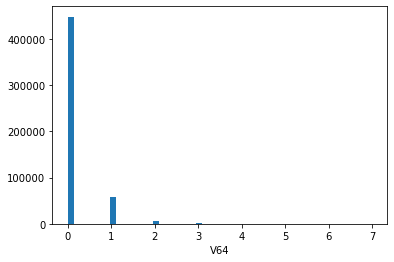

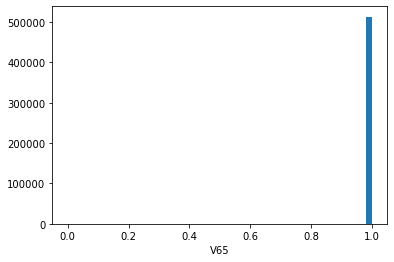

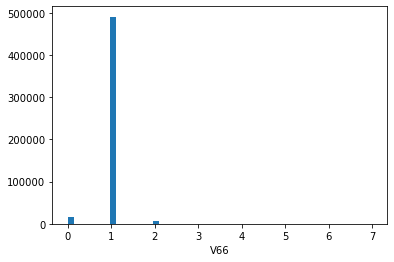

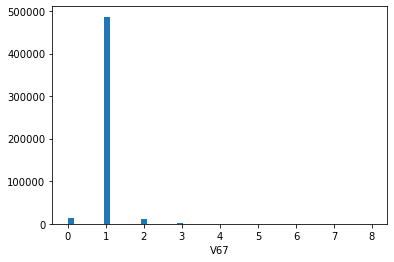

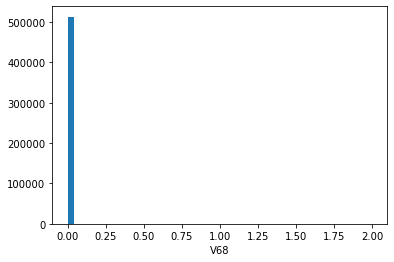

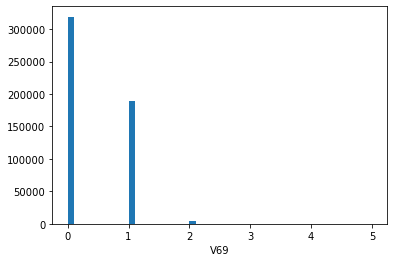

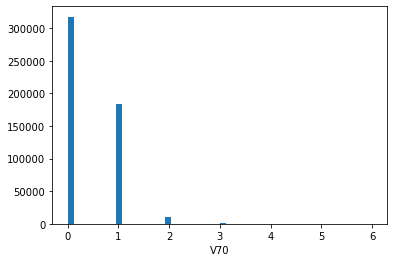

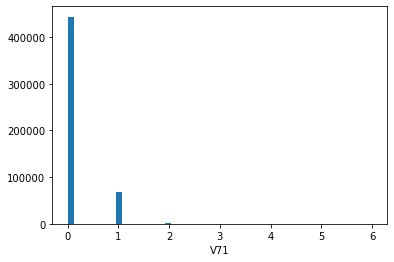

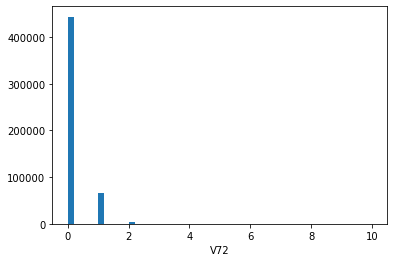

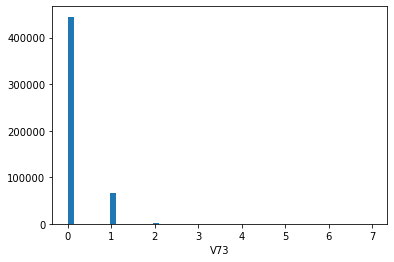

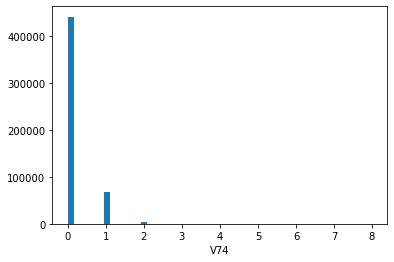

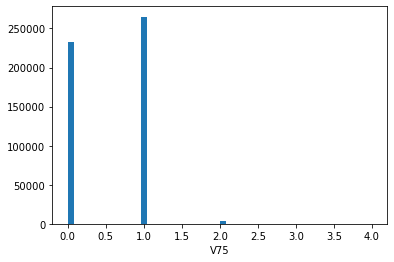

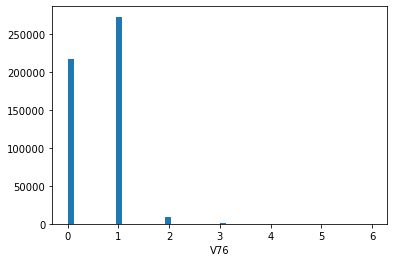

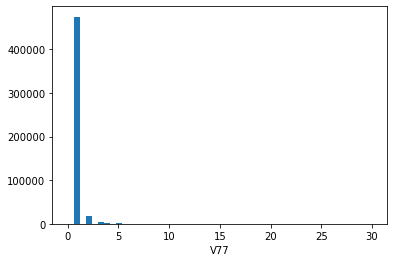

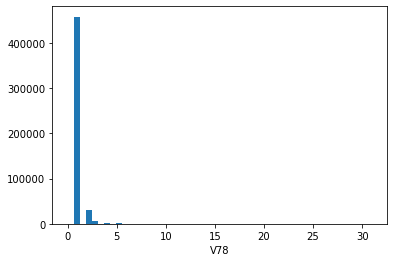

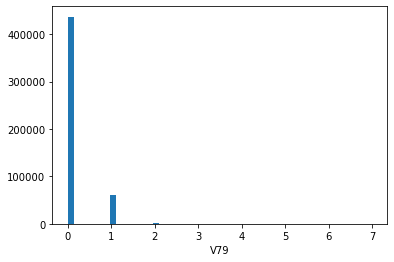

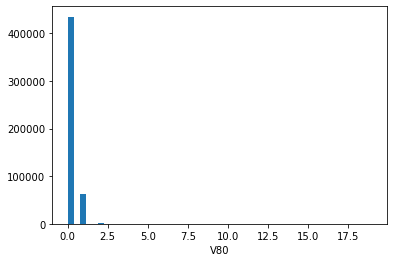

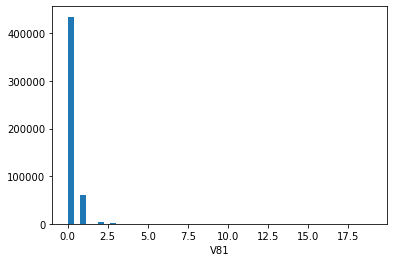

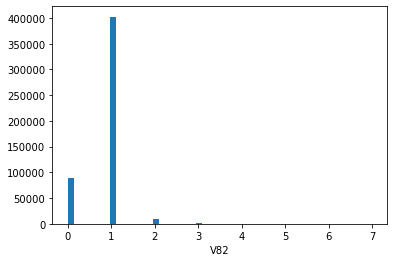

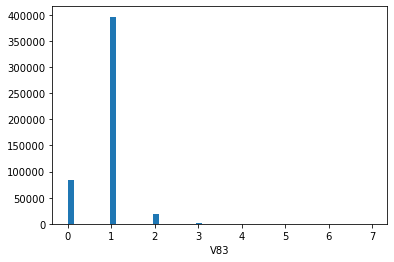

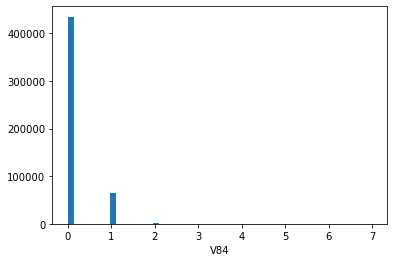

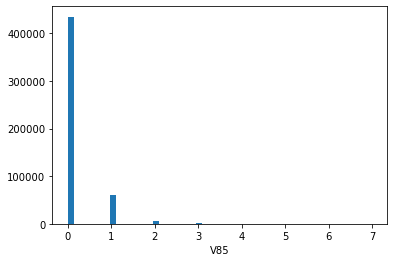

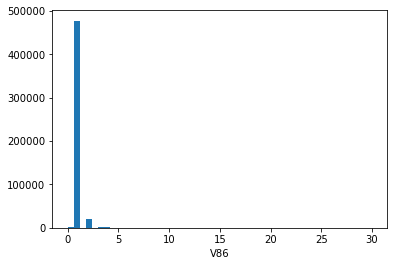

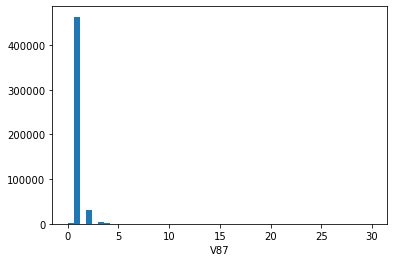

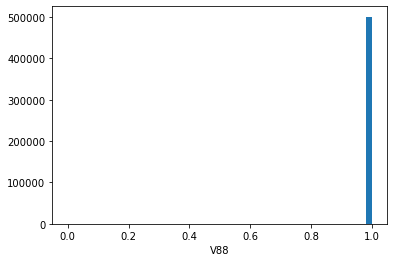

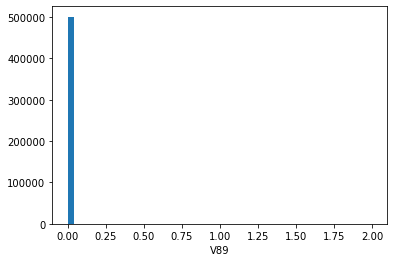

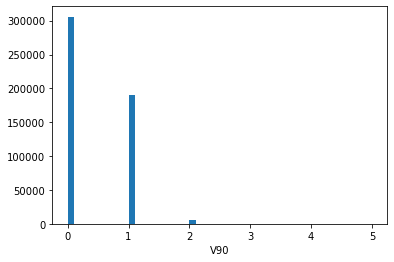

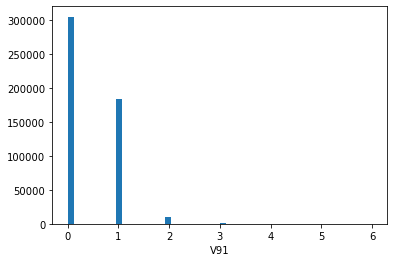

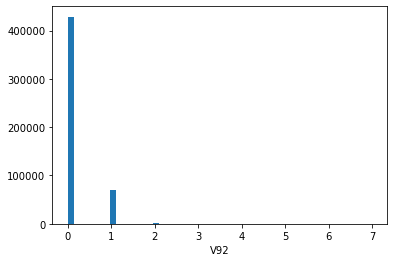

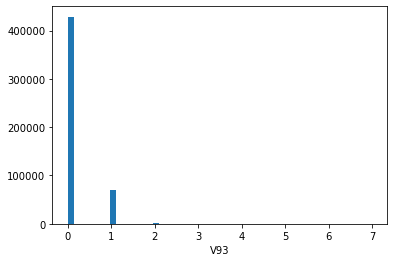

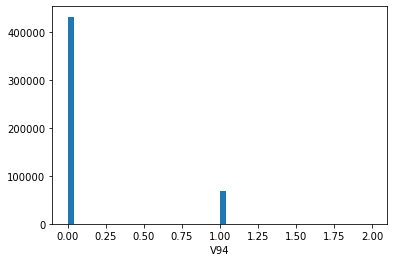

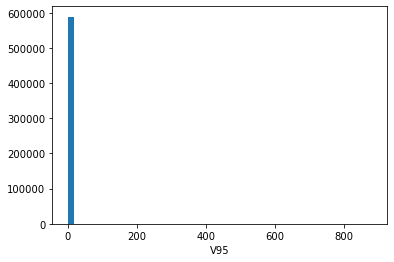

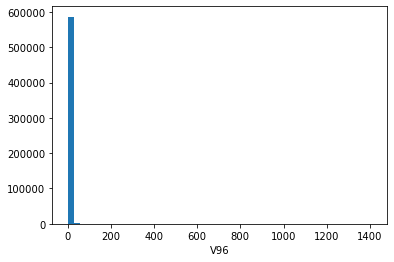

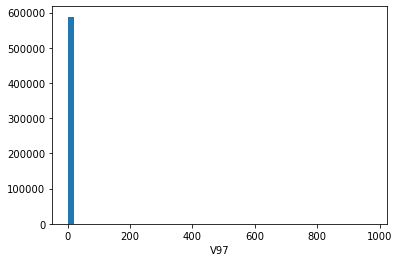

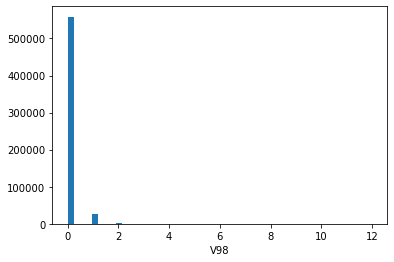

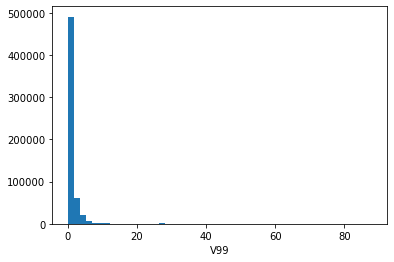

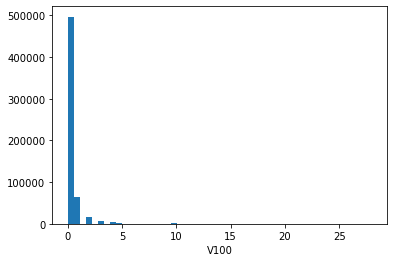

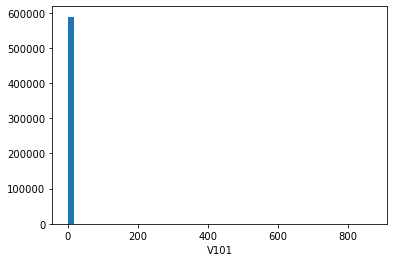

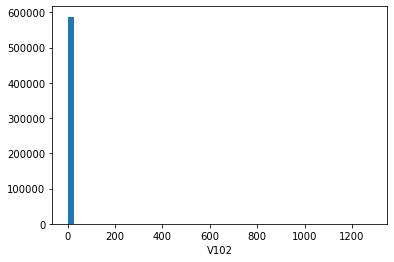

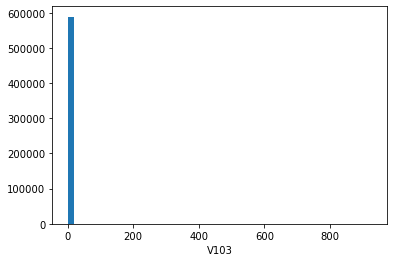

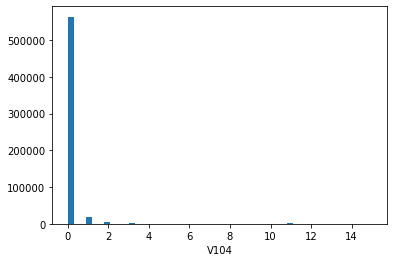

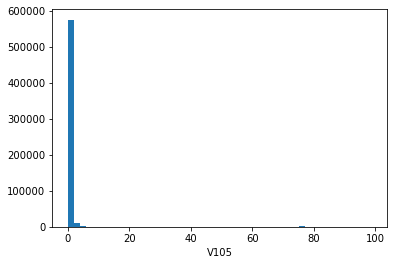

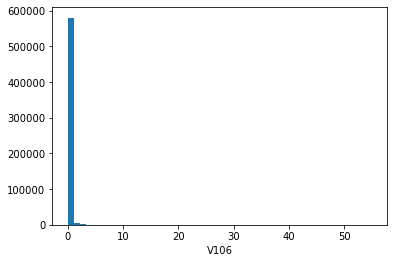

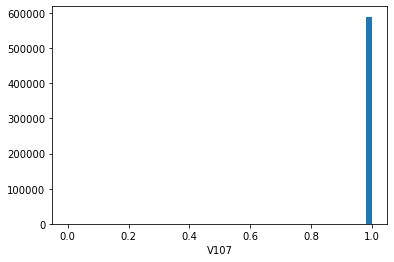

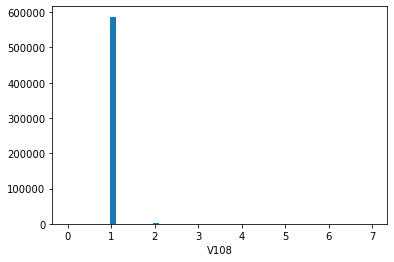

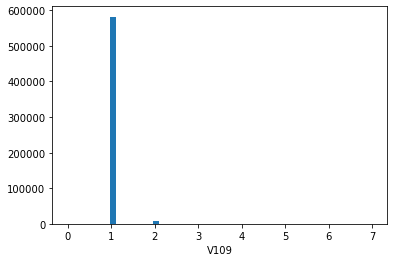

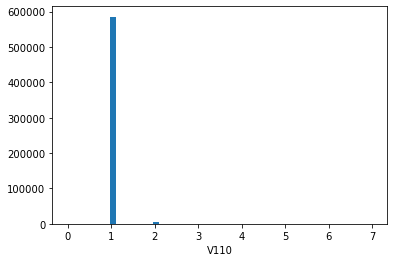

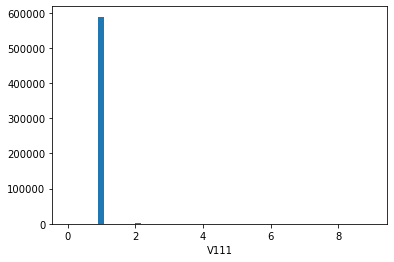

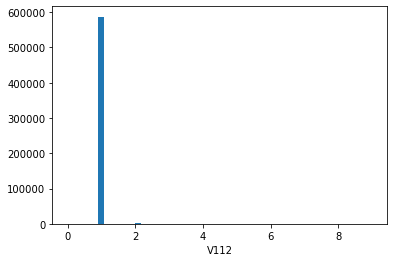

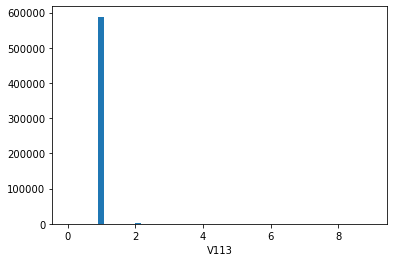

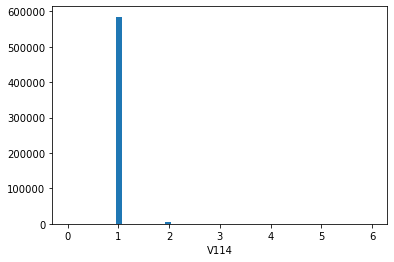

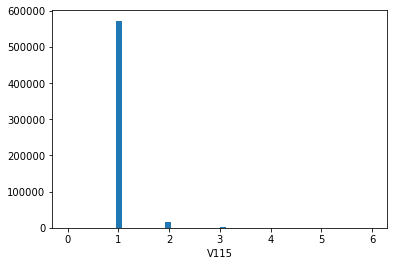

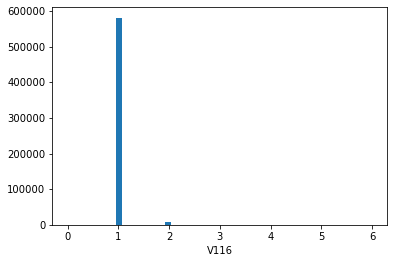

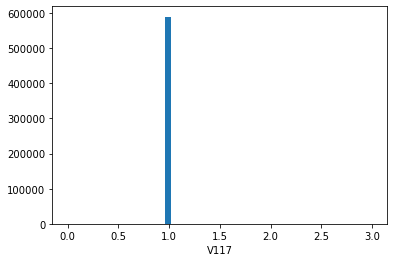

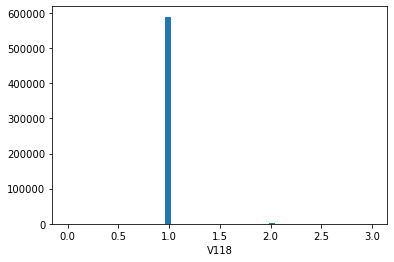

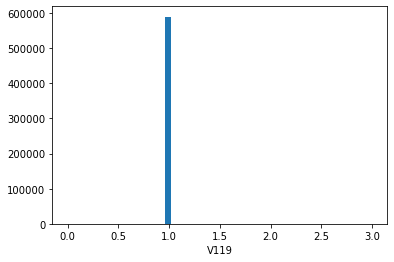

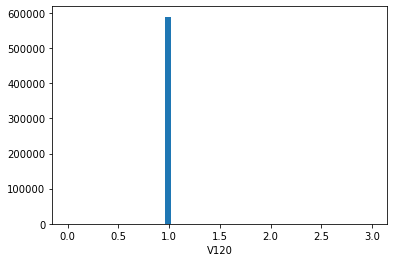

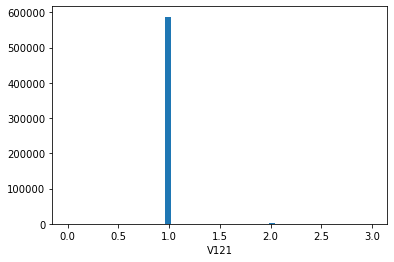

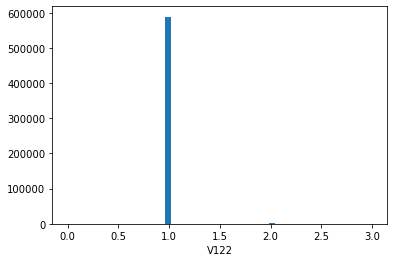

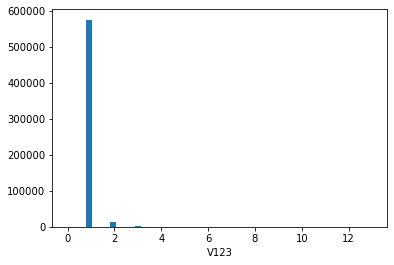

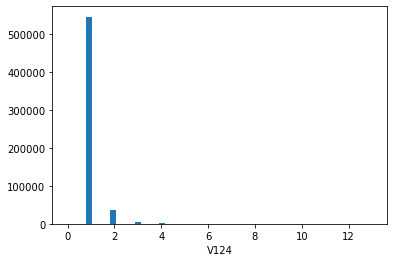

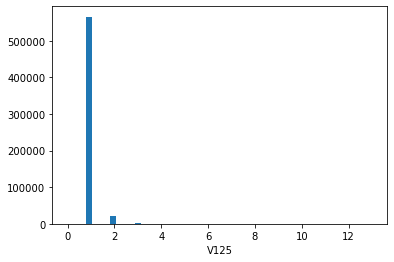

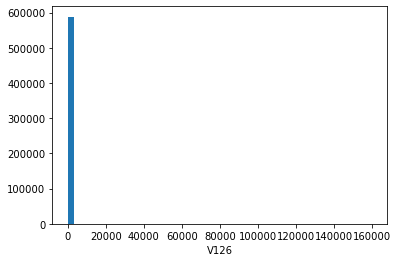

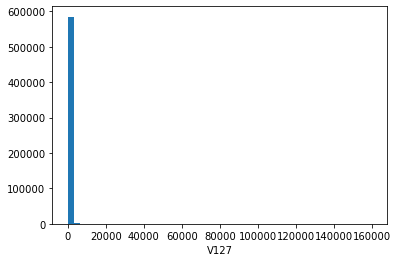

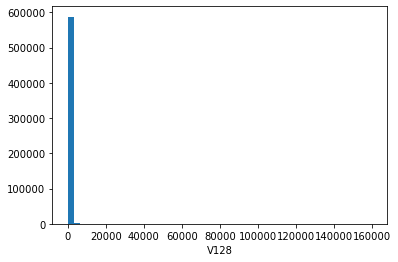

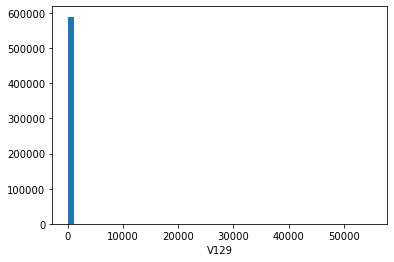

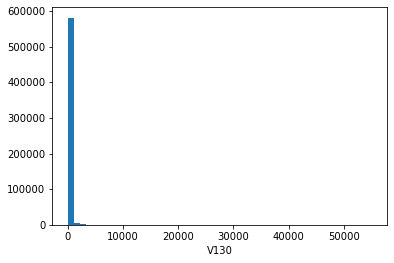

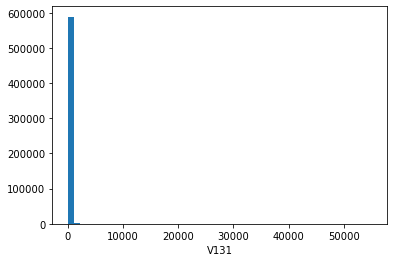

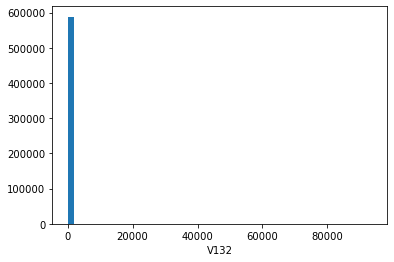

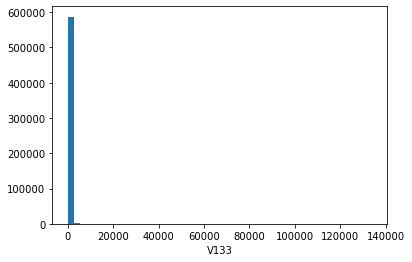

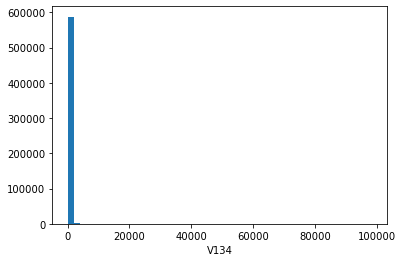

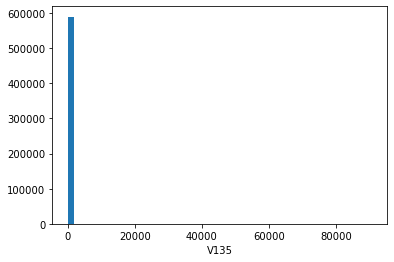

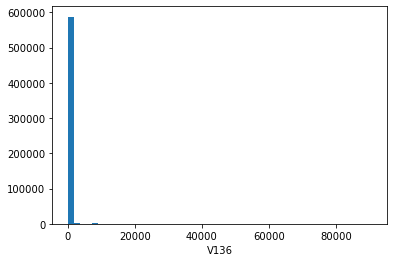

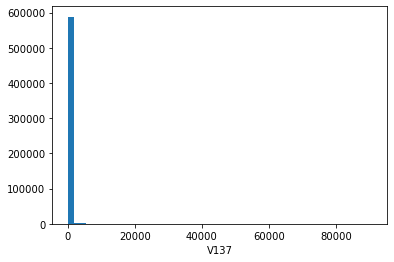

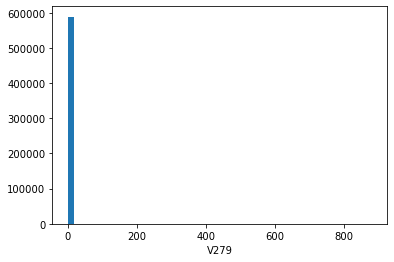

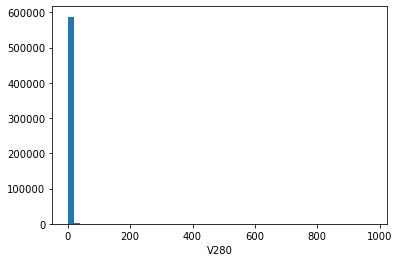

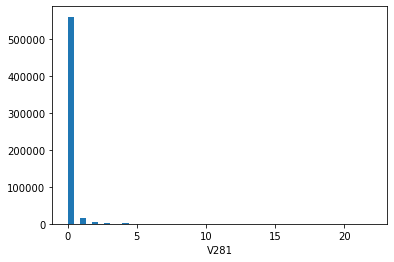

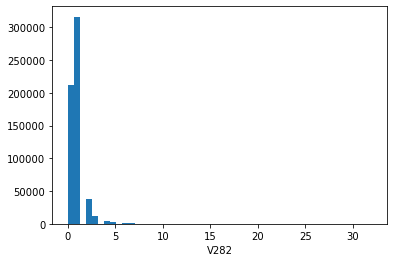

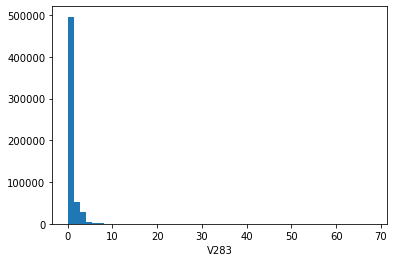

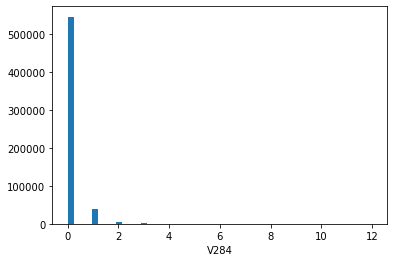

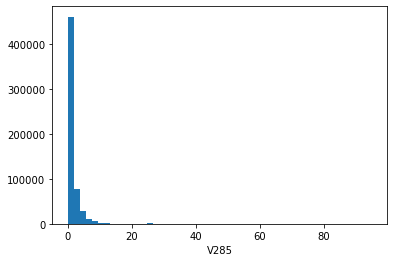

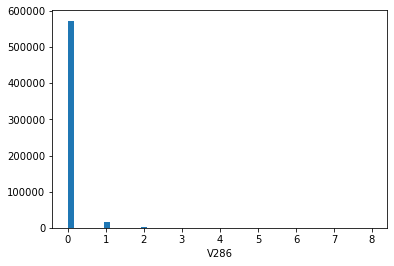

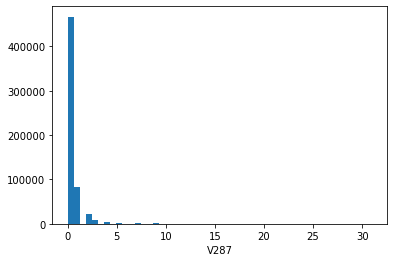

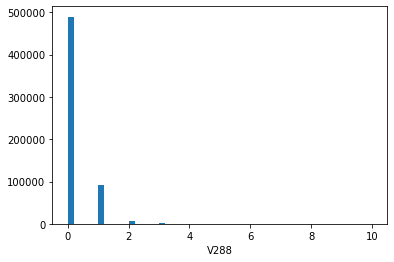

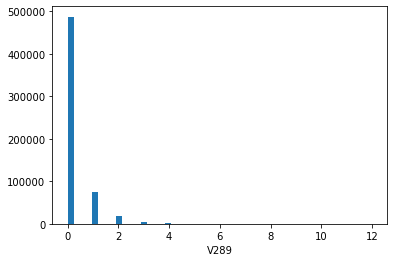

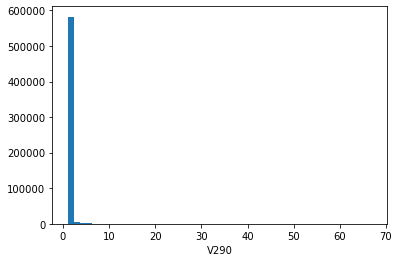

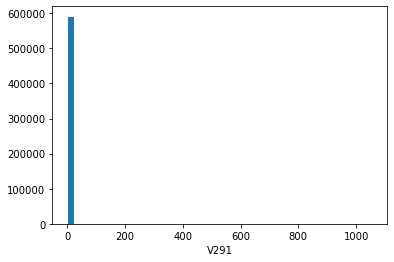

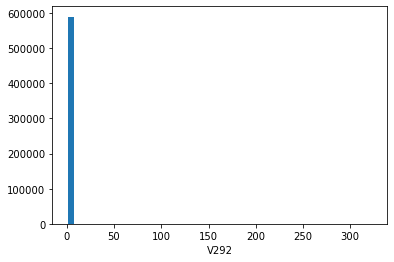

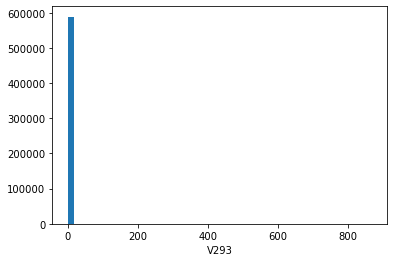

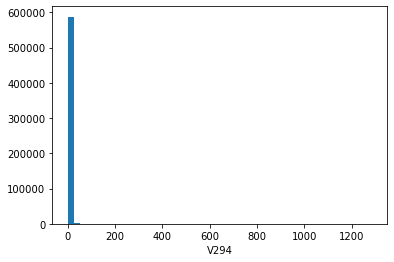

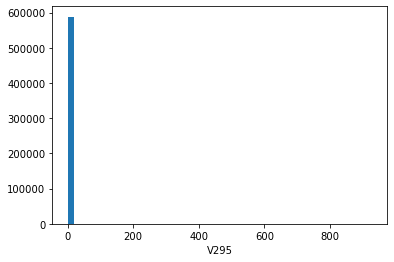

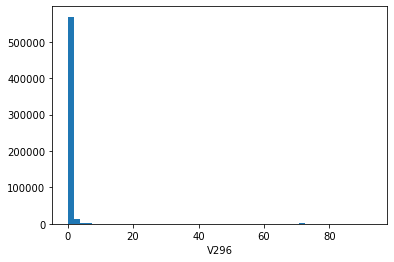

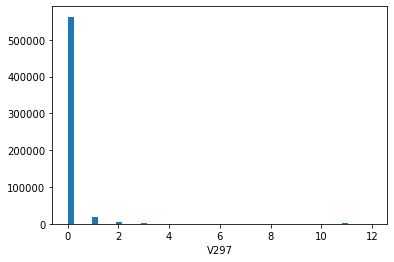

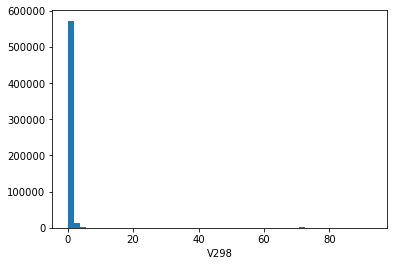

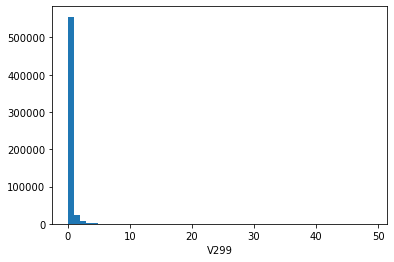

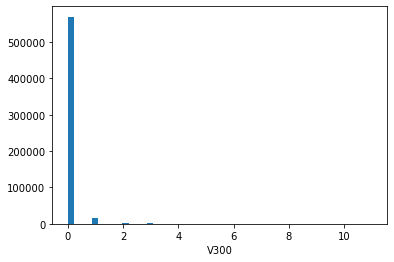

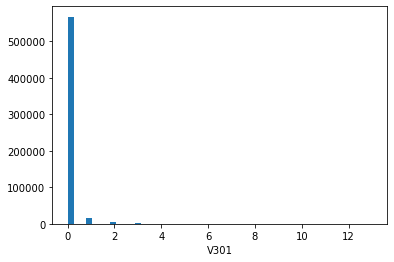

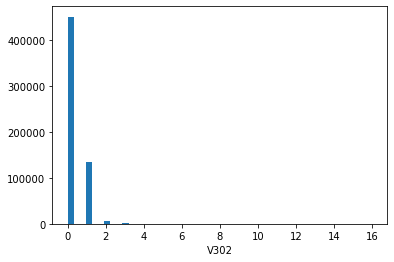

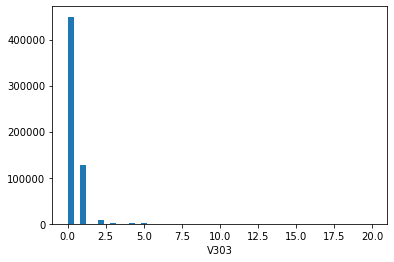

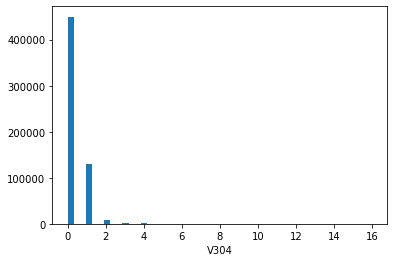

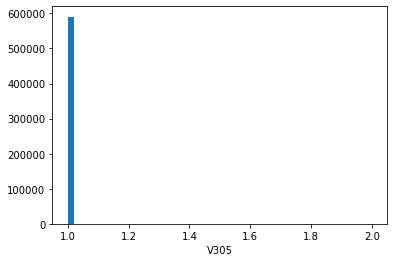

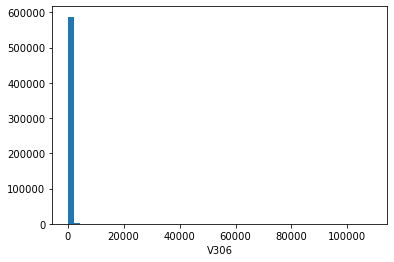

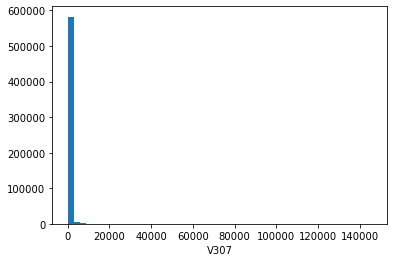

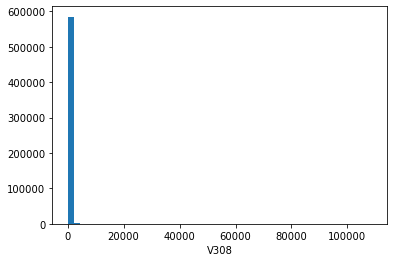

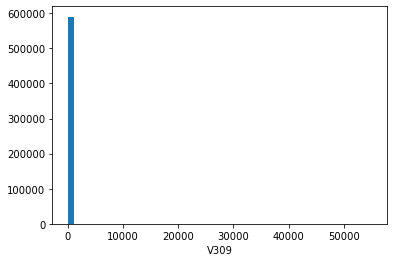

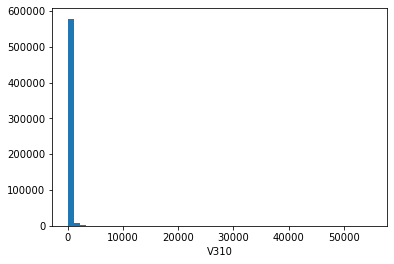

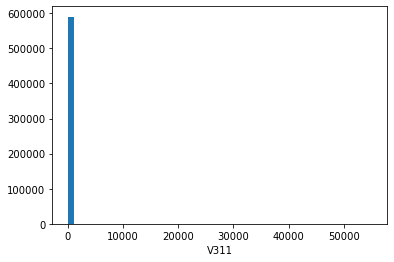

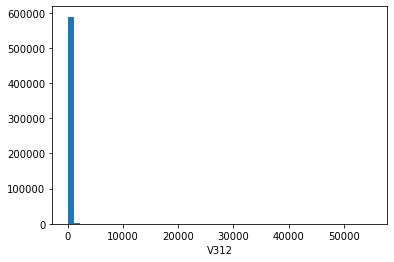

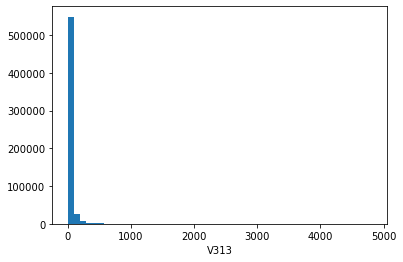

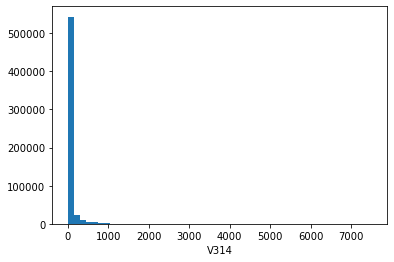

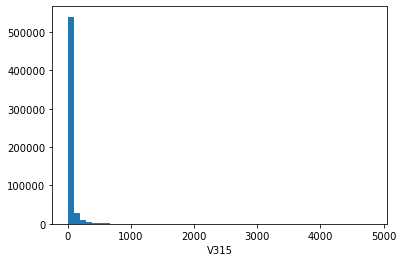

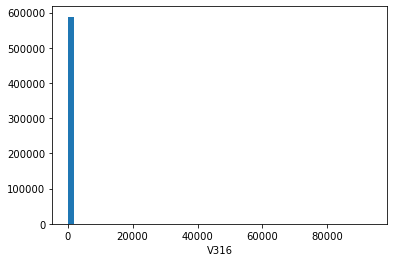

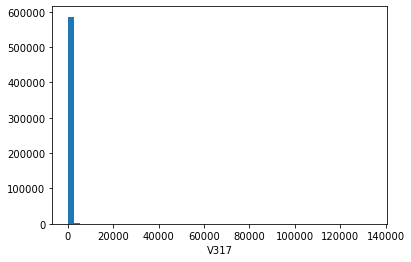

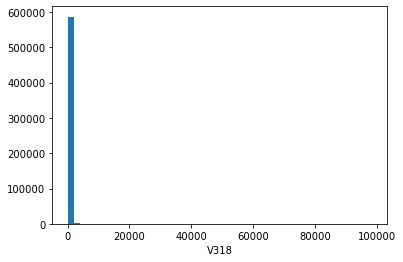

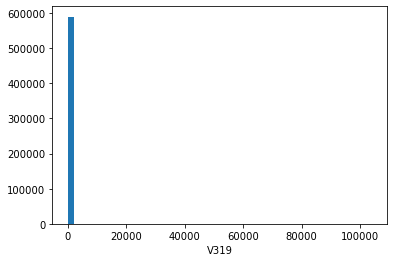

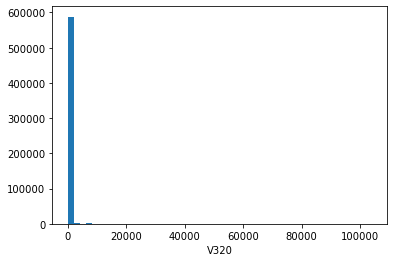

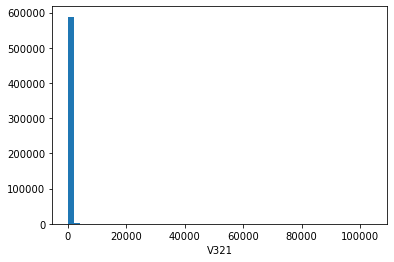

In [21]:
# Гистограмма по признакам
for col in data[num_cols_null]:
    plt.hist(data[col], 50)
    plt.xlabel(col)
    plt.show()

In [22]:
from sklearn.impute import SimpleImputer

#### Импьютация стратегией 'медиана':

In [23]:
# Импьютация столбцов 'D1', 'D10' и 'D15' стратегией 'медиана'
imp_med = SimpleImputer(missing_values=np.nan, strategy='median')
data.loc[:, 'D1'] = imp_med.fit_transform(data[['D1']])
data.loc[:, 'D10'] = imp_med.fit_transform(data[['D10']])
data.loc[:, 'D15'] = imp_med.fit_transform(data[['D15']])
num_cols_null.remove('D1')
num_cols_null.remove('D10')
num_cols_null.remove('D15')

#### Импьютация стратегией 'мода':

In [24]:
# Импьютация остальных столбцов стратегией 'мода'
imp_mod = SimpleImputer(missing_values=np.NaN, strategy='most_frequent')
for item in num_cols_null:
    data.loc[:, item] = imp_mod.fit_transform(data[[item]])

### Обработка пропусков в категориальных данных:

In [25]:
# Выберем категориальные колонки с пропущенными значениями
drop_cat_cols = []
cat_cols_null = []
# Цикл по категориальным колонкам датасета
for col in cat_cols:
    # Количество пустых значений 
    temp_null_count = data[data[col].isnull()].shape[0]
    dt = str(data[col].dtype)
    if temp_null_count > 0:
        cat_cols_null.append(col)
        temp_perc = round((temp_null_count / total_count) * 100.0, 2)
        print('Колонка {}. Тип данных {}. Количество пустых значений {}, {}%.'.format(col, dt, temp_null_count, temp_perc))

Колонка card2. Тип данных float64. Количество пустых значений 8933, 1.51%.
Колонка card3. Тип данных float64. Количество пустых значений 1565, 0.27%.
Колонка card4. Тип данных object. Количество пустых значений 1577, 0.27%.
Колонка card5. Тип данных float64. Количество пустых значений 4259, 0.72%.
Колонка card6. Тип данных object. Количество пустых значений 1571, 0.27%.
Колонка addr1. Тип данных float64. Количество пустых значений 65706, 11.13%.
Колонка addr2. Тип данных float64. Количество пустых значений 65706, 11.13%.
Колонка P_emaildomain. Тип данных object. Количество пустых значений 94456, 15.99%.
Колонка R_emaildomain. Тип данных object. Количество пустых значений 453249, 76.75%.
Колонка M1. Тип данных object. Количество пустых значений 271100, 45.91%.
Колонка M2. Тип данных object. Количество пустых значений 271100, 45.91%.
Колонка M3. Тип данных object. Количество пустых значений 271100, 45.91%.
Колонка M4. Тип данных object. Количество пустых значений 281444, 47.66%.
Колонка 

In [26]:
# Выбор категориальных колонок,
# у которых количество пропущенных значений превышает 16%
for col in cat_cols_null:
    temp_null_count = data[data[col].isnull()].shape[0]
    temp_perc = round((temp_null_count / total_count) * 100.0, 2)
    if temp_perc >= 16:
        drop_cat_cols.append(col)

In [27]:
# Количество категориальных колонок с пропущенными значениями и колонок,
# где процент пропущенных значений превышает 16%
(len(cat_cols_null), len(drop_cat_cols))

(47, 39)

In [28]:
# Удаление категориальных колонок,
# где процент пропущенных значений превышает 16%
data.drop(columns=drop_cat_cols, inplace=True)
# Получившийся размер датасета
data.shape

(590540, 180)

In [29]:
for item in drop_cat_cols:
    cat_cols.remove(item)
    cat_cols_null.remove(item)
print('Количество оставшихся необработанных категориальных колонок: {}'.format(len(cat_cols)))

Количество оставшихся необработанных категориальных колонок: 10


## Кодирование категориальных признаков

In [30]:
# Выберем категориальные колонки
# Цикл по колонкам датасета
for col in cat_cols:
    dt = str(data[col].dtype)
    temp_un = data[col].nunique()
    print('Колонка {}. Тип данных {}. Количество уникальных значений {}.'.format(col, dt, temp_un))

Колонка ProductCD. Тип данных object. Количество уникальных значений 5.
Колонка card1. Тип данных int64. Количество уникальных значений 13553.
Колонка card2. Тип данных float64. Количество уникальных значений 500.
Колонка card3. Тип данных float64. Количество уникальных значений 114.
Колонка card4. Тип данных object. Количество уникальных значений 4.
Колонка card5. Тип данных float64. Количество уникальных значений 119.
Колонка card6. Тип данных object. Количество уникальных значений 4.
Колонка addr1. Тип данных float64. Количество уникальных значений 332.
Колонка addr2. Тип данных float64. Количество уникальных значений 74.
Колонка P_emaildomain. Тип данных object. Количество уникальных значений 59.


### Кодирование категорий наборами бинарных значений (one-hot encoding):

In [31]:
# Выберем категориальные колонки с малым количеством уникальных значений,
# чтобы сильно не расширять признаковое пространство набора данных
col_oh = ['ProductCD', 'card4', 'card6', 'P_emaildomain']
one_hot = pd.get_dummies(data[col_oh].astype(str))
one_hot.head()

,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,card4_american express,card4_discover,card4_mastercard,card4_nan,card4_visa,...,P_emaildomain_web.de,P_emaildomain_windstream.net,P_emaildomain_yahoo.co.jp,P_emaildomain_yahoo.co.uk,P_emaildomain_yahoo.com,P_emaildomain_yahoo.com.mx,P_emaildomain_yahoo.de,P_emaildomain_yahoo.es,P_emaildomain_yahoo.fr,P_emaildomain_ymail.com
0,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
# Замена исходных категориальных колонок наборами бинарных значений
data = data.join(one_hot)
data.drop(columns=col_oh, inplace=True)
for item in col_oh:
    cat_cols.remove(item)

In [33]:
# Первые 5 строк получившегося датасета
data.head()

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,C2,...,P_emaildomain_web.de,P_emaildomain_windstream.net,P_emaildomain_yahoo.co.jp,P_emaildomain_yahoo.co.uk,P_emaildomain_yahoo.com,P_emaildomain_yahoo.com.mx,P_emaildomain_yahoo.de,P_emaildomain_yahoo.es,P_emaildomain_yahoo.fr,P_emaildomain_ymail.com
0,0,68.5,13926,NaN,150.0,142.0,315.0,87.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,0,29.0,2755,404.0,150.0,102.0,325.0,87.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2,0,59.0,4663,490.0,150.0,166.0,330.0,87.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
3,0,50.0,18132,567.0,150.0,117.0,476.0,87.0,2.0,5.0,...,0,0,0,0,1,0,0,0,0,0
4,0,50.0,4497,514.0,150.0,102.0,420.0,87.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0


### Кодирование категорий целочисленными значениями (label encoding):

In [34]:
from sklearn.preprocessing import LabelEncoder

In [35]:
# Label encoding оставшихся категориальных колонок
le = LabelEncoder()
for item in cat_cols:
    data.loc[:, item] = le.fit_transform(data[item])
# Первые 5 строк категориальных колонок после label encoding
data[cat_cols].head()

,card1,card2,card3,card5,addr1,addr2
0,10095,9432,42,38,166,62
1,1372,303,42,2,173,62
2,2833,389,42,58,178,62
3,13341,466,42,14,282,62
4,2712,413,42,2,241,62


In [36]:
# Проверка, что в датасете не осталось пропущенных значений
print('Количество пропущенных значений: {}'.format(data.isnull().sum().sum()))

Количество пропущенных значений: 0


## Масштабирование данных

### MinMax масштабирование

In [37]:
from sklearn.preprocessing import MinMaxScaler

In [38]:
# Выберем колонки с количеством уникальных значений больше 2
cols = []
for col in num_cols:
    temp_un = data[col].nunique()
    if temp_un > 2:
        cols.append(col)
    print('Колонка {}. Количество уникальных значений {}.'.format(col, temp_un))

Колонка isFraud. Количество уникальных значений 2.
Колонка TransactionAmt. Количество уникальных значений 20902.
Колонка C1. Количество уникальных значений 1657.
Колонка C2. Количество уникальных значений 1216.
Колонка C3. Количество уникальных значений 27.
Колонка C4. Количество уникальных значений 1260.
Колонка C5. Количество уникальных значений 319.
Колонка C6. Количество уникальных значений 1328.
Колонка C7. Количество уникальных значений 1103.
Колонка C8. Количество уникальных значений 1253.
Колонка C9. Количество уникальных значений 205.
Колонка C10. Количество уникальных значений 1231.
Колонка C11. Количество уникальных значений 1476.
Колонка C12. Количество уникальных значений 1199.
Колонка C13. Количество уникальных значений 1597.
Колонка C14. Количество уникальных значений 1108.
Колонка D1. Количество уникальных значений 641.
Колонка D10. Количество уникальных значений 818.
Колонка D15. Количество уникальных значений 859.
Колонка V12. Количество уникальных значений 4.
Колонка

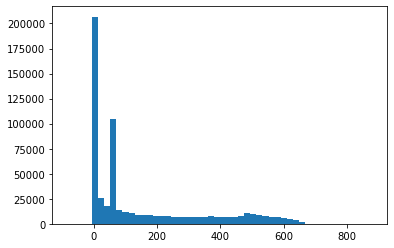

In [39]:
# Гистограмма распределения какого-нибудь числового признака
plt.hist(data['D15'], 50)
plt.show()

In [40]:
# MinMax масштабирование
mms = MinMaxScaler()
for item in cols:
    data.loc[:, item] = mms.fit_transform(data[[item]])

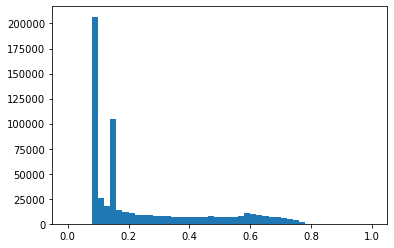

In [41]:
# Гистограмма распределения этого признака после масштабирования
plt.hist(data['D15'], 50)
plt.show()

**Вывод.** MinMax масштабирование изменило диапазон измерения величины на 0...1 и не повлияло на распределение этой величины.

## Корреляционный анализ данных
Проверка корреляции признаков позволяет решить две задачи:
- Понять какие признаки (колонки датасета) наиболее сильно коррелируют с целевым признаком. Наличие сильной корреляции с целевым признаком говорит о линейной зависимости этих признаков и сильно облегчает задау построения моделей машинного обучения.
- Понять какие нецелевые признаки линейно зависимы между собой. Линейно зависимые признаки, как правило, очень плохо влияют на качество моделей. Поэтому если несколько признаков линейно зависимы, то для построения модели из них выбирают какой-то один признак.

In [42]:
# Вывод наиболее коррелирующих признаков с целевым признаком
corrFr = data[data.columns.drop(cat_cols)].corrwith(data['isFraud']).sort_values(ascending=False)
corrFr

isFraud        1.000000
V86            0.222343
V87            0.221568
V79            0.167299
V94            0.161454
                 ...   
card6_debit   -0.099779
V69           -0.102396
V90           -0.102635
V29           -0.102738
ProductCD_W   -0.135549
Length: 245, dtype: float64

**Вывод.** Данный набор данных не содержит простых зависимостей с целевым признаком.

In [43]:
# Анализ сильно коррелированных признаков и удаление одного из них из датасета
drop_col = []
for col in corrFr.index:
    if col not in drop_col:
        tmp = data[data.columns.drop(cat_cols)].corrwith(data[col])
        flg = True
        for i in range(1, tmp.shape[0]):
            if col is not tmp.index[i]:
                if abs(tmp[i]) > 0.98:
                    if flg:
                        print('Признак {} имеет корреляцию с целевым признаком: {}.'.format(col, corrFr[col]))
                        flg = False
                    print('Признак {} имеет корреляцию с признаком {}: {}.'.format(col, tmp.index[i], tmp[i]))
                    print('Признак {} имеет корреляцию с целевым признаком: {}.'.format(tmp.index[i], corrFr[tmp.index[i]]))
                    if abs(corrFr[col]) < abs(corrFr[tmp.index[i]]):
                        print('Удаляем признак {}, т.к. он меньше коллерирует с целевым признаком.'.format(col))
                        data.drop(columns=col, inplace=True)
                        drop_col.append(col)
                        break;
                    else:
                        print('Удаляем признак {}, т.к. он меньше коллерирует с целевым признаком.'.format(tmp.index[i]))
                        data.drop(columns=tmp.index[i], inplace=True)
                        drop_col.append(tmp.index[i])
        if not flg:
            print()

Признак V17 имеет корреляцию с целевым признаком: 0.15897168090753624.
Признак V17 имеет корреляцию с признаком V18: 0.9916176966010278.
Признак V18 имеет корреляцию с целевым признаком: 0.1589329174050446.
Удаляем признак V18, т.к. он меньше коллерирует с целевым признаком.

Признак V15 имеет корреляцию с целевым признаком: 0.15475457773791504.
Признак V15 имеет корреляцию с признаком V16: 0.986945558622141.
Признак V16 имеет корреляцию с целевым признаком: 0.15164513658016676.
Удаляем признак V16, т.к. он меньше коллерирует с целевым признаком.

Признак V31 имеет корреляцию с целевым признаком: 0.1410017948405061.
Признак V31 имеет корреляцию с признаком V32: 0.9864628749581449.
Признак V32 имеет корреляцию с целевым признаком: 0.13851735945669646.
Удаляем признак V32, т.к. он меньше коллерирует с целевым признаком.

Признак card6_credit имеет корреляцию с целевым признаком: 0.10050758519378097.
Признак card6_credit имеет корреляцию с признаком card6_debit: -0.992798670400973.
Призна


Признак V103 имеет корреляцию с целевым признаком: -0.0051213962788120675.
Признак V103 имеет корреляцию с признаком V96: 0.9906763028805136.
Признак V96 имеет корреляцию с целевым признаком: -0.005486367407023405.
Удаляем признак V103, т.к. он меньше коллерирует с целевым признаком.



In [44]:
# Окончательный датасет
data.head()

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C2,C3,...,P_emaildomain_web.de,P_emaildomain_windstream.net,P_emaildomain_yahoo.co.jp,P_emaildomain_yahoo.co.uk,P_emaildomain_yahoo.com,P_emaildomain_yahoo.com.mx,P_emaildomain_yahoo.de,P_emaildomain_yahoo.es,P_emaildomain_yahoo.fr,P_emaildomain_ymail.com
0,0,0.002137,10095,9432,42,38,166,62,0.000176,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0,0.000900,1372,303,42,2,173,62,0.000176,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0,0.001840,2833,389,42,58,178,62,0.000176,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0,0.001558,13341,466,42,14,282,62,0.000879,0.0,...,0,0,0,0,1,0,0,0,0,0
4,0,0.001558,2712,413,42,2,241,62,0.000176,0.0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
# Окончательный размер датасета
data.shape

(590540, 220)

In [46]:
# Сохранение получившегося датасета
data.to_csv('E:/train.csv')

## Выбор метрик для последующей оценки качества моделей
### В качестве метрик для решения задачи классификации будем использовать:
#### Метрика Balanced Accuracy:
Метрика используется для работы с несбалансированными наборами данных (как данный датасет). Она определяет средний процент (долю в диапазоне от 0 до 1) правильно определенных классов по каждому классу.

Используется функция [balanced_accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html#sklearn.metrics.balanced_accuracy_score).

In [47]:
from sklearn.metrics import balanced_accuracy_score 

#### Метрика recall (полнота):
$recall = \frac{TP}{TP+FN}$

Доля верно предсказанных классификатором положительных объектов, из всех действительно положительных объектов. Эта метрика в данной предметной области позволяет оценить количество мошеннических транзакций, которые были ошибочно приняты за обычные, что является очень важной оценкой.

Используется функция [recall_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score).

In [48]:
from sklearn.metrics import recall_score

#### Метрика ROC AUC:
Используется для оценки качества бинарной классификации. Данная метрика используется для оценки качества модели на сайте соревнования с данным датасетом.

Основана на вычислении следующих характеристик:

$TPR = \frac{TP}{TP+FN}$ - True Positive Rate, откладывается по оси ординат. Совпадает с recall.

$FPR = \frac{FP}{FP+TN}$ - False Positive Rate, откладывается по оси абсцисс. Показывает какую долю из объектов отрицательного класса алгоритм предсказал неверно.

Идеальная ROC-кривая проходит через точки (0,0)-(0,1)-(1,1), то есть через верхний левый угол графика.

Чем сильнее отклоняется кривая от верхнего левого угла графика, тем хуже качество классификации.


В качестве количественной метрики используется площадь под кривой - ROC AUC (Area Under the Receiver Operating Characteristic Curve). Чем ниже проходит кривая, тем меньше ее площадь и тем хуже качество классификатора.

Для получения ROC AUC используется функция [roc_auc_score.](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)

In [49]:
from sklearn.metrics import roc_auc_score 

## Выбор моделей для решения задачи классификации
Для задачи классификации будем использовать следующие модели:
- Метод ближайших соседей
- Машина опорных векторов
- Решающее дерево
- Случайный лес
- Градиентный бустинг

Модели "Случайный лес" и "Градиентный бустинг" являются ансамблевыми моделями.

## Формирование обучающей и тестовой выборок на основе исходного набора данных
### Используем метод train_test_split:

In [50]:
from sklearn.model_selection import train_test_split

In [51]:
data_train, data_test, data_y_train, data_y_test = train_test_split(data[data.columns.drop('isFraud')], data['isFraud'], random_state=1)
# Размер обучающей и тестовой выборок
(data_train.shape, data_test.shape, data_y_train.shape, data_y_test.shape)

((442905, 219), (147635, 219), (442905,), (147635,))

## Построение базового решения (baseline) для выбранных моделей без подбора гиперпараметров
### Модель "Метод ближайших соседей":

In [52]:
from sklearn.neighbors import KNeighborsClassifier

In [53]:
# Словари для сохранения значений метрик разных моделей
baseline_predicted_rocauc = {}
baseline_predicted_recall = {}
baseline_predicted_bAccur = {}

In [54]:
KNC = KNeighborsClassifier(n_jobs=-1).fit(data_train, data_y_train)
predict = KNC.predict(data_test)
predict_p = KNC.predict_proba(data_test)
# Сохранение значений оценок метрик для данной модели
baseline_predicted_rocauc["KN"] = roc_auc_score(data_y_test, predict_p[:,1])
baseline_predicted_recall["KN"] = recall_score(data_y_test, predict)
baseline_predicted_bAccur["KN"] = balanced_accuracy_score(data_y_test, predict)

In [55]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve

# Отрисовка ROC-кривой
def draw_roc_curve(y_true, y_score, ax, pos_label=1, average='micro'):
    fpr, tpr, thresholds = roc_curve(y_true, y_score, 
                                     pos_label=pos_label)
    roc_auc_value = roc_auc_score(y_true, y_score, average=average)
    lw = 2
    ax.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_value)
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_xlim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")

# Отрисовка ROC-кривой c матрицей ошибок
def draw_m(model, modelName, data_test, data_y_test, predict_p):
    fig, ax = plt.subplots(ncols=2, figsize=(10,5))
    draw_roc_curve(data_y_test, predict_p, ax[0])
    plot_confusion_matrix(model, data_test, data_y_test, ax=ax[1],
                      display_labels=['0','1'], 
                      cmap=plt.cm.Blues, normalize='true')
    fig.suptitle(modelName)
    plt.show()

Метод ближайших соседей:
ROC AUC:  0.8372066763690009
Recall:  0.3754379135850526
Balanced Accuracy:  0.6841223898472573


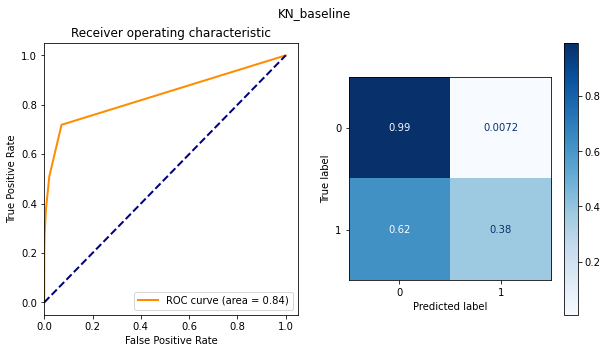

In [56]:
print('Метод ближайших соседей:')
print('ROC AUC: ', baseline_predicted_rocauc["KN"])
print('Recall: ', baseline_predicted_recall["KN"])
print('Balanced Accuracy: ', baseline_predicted_bAccur["KN"])
draw_m(KNC, 'KN_baseline', data_test, data_y_test, predict_p[:,1])

### Модель "Машина опорных векторов":

In [57]:
from sklearn.svm import SVC

In [58]:
svc = SVC(kernel='rbf', random_state=1, probability=True, cache_size=2000, max_iter=100).fit(data_train, data_y_train)
predict = svc.predict(data_test)
predict_p = svc.predict_proba(data_test)
# Сохранение значений оценок метрик для данной модели
baseline_predicted_rocauc["SVC"] = roc_auc_score(data_y_test, predict_p[:,1])
baseline_predicted_recall["SVC"] = recall_score(data_y_test, predict)
baseline_predicted_bAccur["SVC"] = balanced_accuracy_score(data_y_test, predict)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Машина опорных векторов:
ROC AUC:  0.5791999785409971
Recall:  0.041650447644998055
Balanced Accuracy:  0.5162216181325547


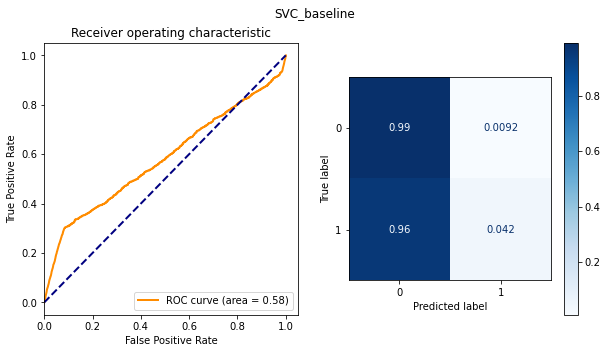

In [59]:
print('Машина опорных векторов:')
print('ROC AUC: ', baseline_predicted_rocauc["SVC"])
print('Recall: ', baseline_predicted_recall["SVC"])
print('Balanced Accuracy: ', baseline_predicted_bAccur["SVC"])
draw_m(svc, 'SVC_baseline', data_test, data_y_test, predict_p[:,1])

### Модель "Решающее дерево":

In [60]:
from sklearn.tree import DecisionTreeClassifier

In [61]:
dtc = DecisionTreeClassifier(random_state=1).fit(data_train, data_y_train)
predict = dtc.predict(data_test)
predict_p = dtc.predict_proba(data_test)
# Сохранение значений оценок метрик для данной модели
baseline_predicted_rocauc["DT"] = roc_auc_score(data_y_test, predict_p[:,1])
baseline_predicted_recall["DT"] = recall_score(data_y_test, predict)
baseline_predicted_bAccur["DT"] = balanced_accuracy_score(data_y_test, predict)

Решающее дерево:
ROC AUC:  0.786755931457974
Recall:  0.591475282210977
Balanced Accuracy:  0.7866988543240123


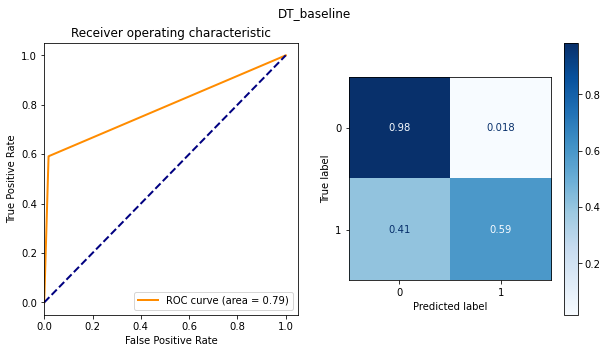

In [62]:
print('Решающее дерево:')
print('ROC AUC: ', baseline_predicted_rocauc["DT"])
print('Recall: ', baseline_predicted_recall["DT"])
print('Balanced Accuracy: ', baseline_predicted_bAccur["DT"])
draw_m(dtc, 'DT_baseline', data_test, data_y_test, predict_p[:,1])

### Модель "Случайный лес":

In [63]:
from sklearn.ensemble import RandomForestClassifier

In [64]:
RFC = RandomForestClassifier(random_state=1, n_jobs=-1).fit(data_train, data_y_train)
predict = RFC.predict(data_test)
predict_p = RFC.predict_proba(data_test)
# Сохранение значений оценок метрик для данной модели
baseline_predicted_rocauc["RF"] = roc_auc_score(data_y_test, predict_p[:,1])
baseline_predicted_recall["RF"] = recall_score(data_y_test, predict)
baseline_predicted_bAccur["RF"] = balanced_accuracy_score(data_y_test, predict)

Случайный лес:
ROC AUC:  0.9328265098547771
Recall:  0.48871156091864537
Balanced Accuracy:  0.7435662901542637


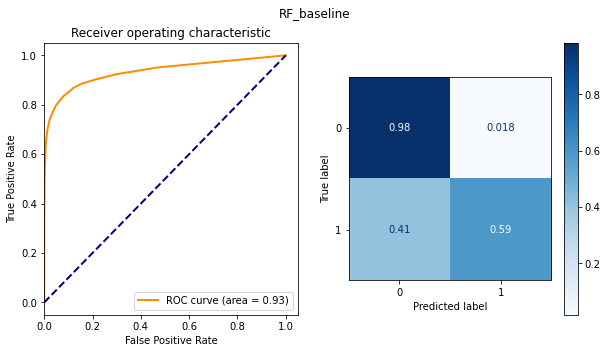

In [65]:
print('Случайный лес:')
print('ROC AUC: ', baseline_predicted_rocauc["RF"])
print('Recall: ', baseline_predicted_recall["RF"])
print('Balanced Accuracy: ', baseline_predicted_bAccur["RF"])
draw_m(dtc, 'RF_baseline', data_test, data_y_test, predict_p[:,1])

### Модель "Градиентный бустинг":

In [66]:
from lightgbm import LGBMClassifier

In [67]:
LGBMC = LGBMClassifier(random_state=1).fit(data_train, data_y_train)
predict = LGBMC.predict(data_test)
predict_p = LGBMC.predict_proba(data_test)
# Сохранение значений оценок метрик для данной модели
baseline_predicted_rocauc["LGBM"] = roc_auc_score(data_y_test, predict_p[:,1])
baseline_predicted_recall["LGBM"] = recall_score(data_y_test, predict)
baseline_predicted_bAccur["LGBM"] = balanced_accuracy_score(data_y_test, predict)

Градиентный бустинг:
ROC AUC:  0.9238636891068323
Recall:  0.40054495912806537
Balanced Accuracy:  0.6992303523613548


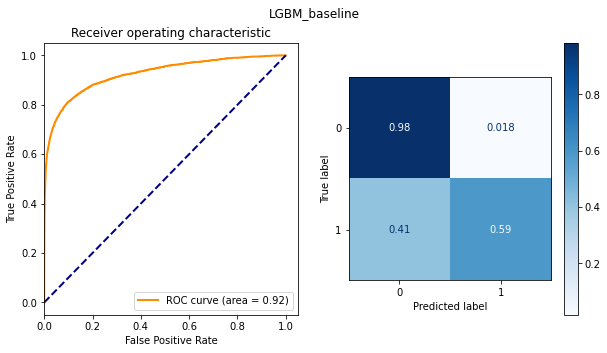

In [68]:
print('Градиентный бустинг:')
print('ROC AUC: ', baseline_predicted_rocauc["LGBM"])
print('Recall: ', baseline_predicted_recall["LGBM"])
print('Balanced Accuracy: ', baseline_predicted_bAccur["LGBM"])
draw_m(dtc, 'LGBM_baseline', data_test, data_y_test, predict_p[:,1])

## Подбор гиперпараметров для выбранных моделей
### Модель "Метод ближайших соседей":

In [69]:
from sklearn.model_selection import GridSearchCV

In [70]:
# Гиперпараметры
n_range = np.array(range(0,11,5))
n_range[0] = 1
tuned_parameters = [{'n_neighbors': n_range}]

In [71]:
%%time
GSCV = GridSearchCV(KNeighborsClassifier(n_jobs=-1), tuned_parameters, cv=3, scoring='roc_auc')
GSCV.fit(data_train, data_y_train)

Wall time: 13min 26s


GridSearchCV(cv=3, estimator=KNeighborsClassifier(n_jobs=-1),
             param_grid=[{'n_neighbors': array([ 1,  5, 10])}],
             scoring='roc_auc')

In [72]:
# Лучшее значение параметров
GSCV.best_params_

{'n_neighbors': 10}

In [73]:
gscv_predicted_rocauc = {}
gscv_predicted_recall = {}
gscv_predicted_bAccur = {}

In [74]:
predict = GSCV.best_estimator_.predict(data_test)
predict_p = GSCV.best_estimator_.predict_proba(data_test)
# Сохранение значений оценок метрик для данной модели
gscv_predicted_rocauc["KN"] = roc_auc_score(data_y_test, predict_p[:,1])
gscv_predicted_recall["KN"] = recall_score(data_y_test, predict)
gscv_predicted_bAccur["KN"] = balanced_accuracy_score(data_y_test, predict)

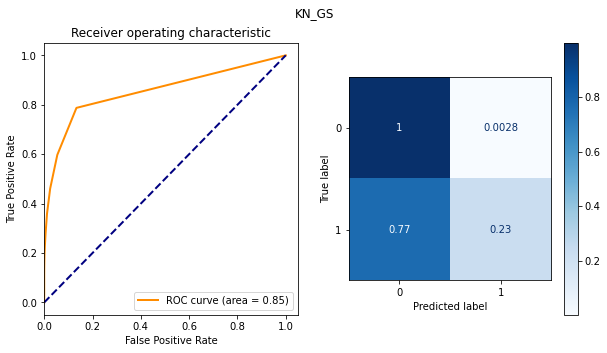

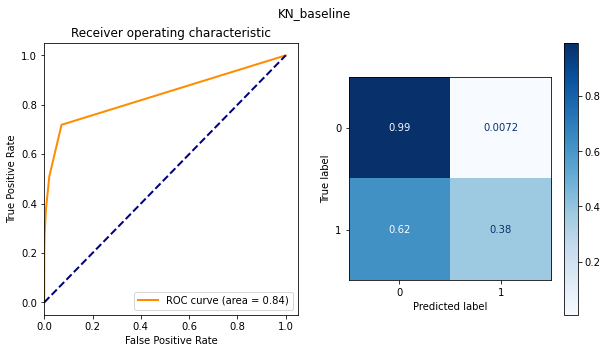

Метод ближайших соседей (Grid Search):
ROC AUC:  0.8534342243007154
Recall:  0.2298559750875827
Balanced Accuracy:  0.6135104138404853

Метод ближайших соседей (Baseline):
ROC AUC:  0.8372066763690009
Recall:  0.3754379135850526
Balanced Accuracy:  0.6841223898472573


In [75]:
# Сравнение baseline модели с найденной лучшей моделью
draw_m(GSCV.best_estimator_, 'KN_GS', data_test, data_y_test, predict_p[:,1])
draw_m(KNC, 'KN_baseline', data_test, data_y_test, KNC.predict_proba(data_test)[:,1])
print('Метод ближайших соседей (Grid Search):')
print('ROC AUC: ', gscv_predicted_rocauc["KN"])
print('Recall: ', gscv_predicted_recall["KN"])
print('Balanced Accuracy: ', gscv_predicted_bAccur["KN"])
print()
print('Метод ближайших соседей (Baseline):')
print('ROC AUC: ', baseline_predicted_rocauc["KN"])
print('Recall: ', baseline_predicted_recall["KN"])
print('Balanced Accuracy: ', baseline_predicted_bAccur["KN"])

Подбор гиперпараметров улучшил качество модели.

### Модель "Машина опорных векторов":

In [76]:
# Гиперпараметры
n_range = np.array(range(0, 3, 1))
n_range[0] = 0.1
tuned_parameters = [{'C': n_range}]

In [77]:
%%time
GSCV = GridSearchCV(SVC(kernel='rbf', random_state=1, probability=True, max_iter=100), tuned_parameters, cv=3, scoring='roc_auc', n_jobs=-1)
GSCV.fit(data_train, data_y_train)

Wall time: 9min


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


GridSearchCV(cv=3,
             estimator=SVC(max_iter=100, probability=True, random_state=1),
             n_jobs=-1, param_grid=[{'C': array([0, 1, 2])}],
             scoring='roc_auc')

In [78]:
# Лучшее значение параметров
GSCV.best_params_

{'C': 1}

In [79]:
predict = GSCV.best_estimator_.predict(data_test)
predict_p = GSCV.best_estimator_.predict_proba(data_test)
# Сохранение значений оценок метрик для данной модели
gscv_predicted_rocauc["SVC"] = roc_auc_score(data_y_test, predict_p[:,1])
gscv_predicted_recall["SVC"] = recall_score(data_y_test, predict)
gscv_predicted_bAccur["SVC"] = balanced_accuracy_score(data_y_test, predict)

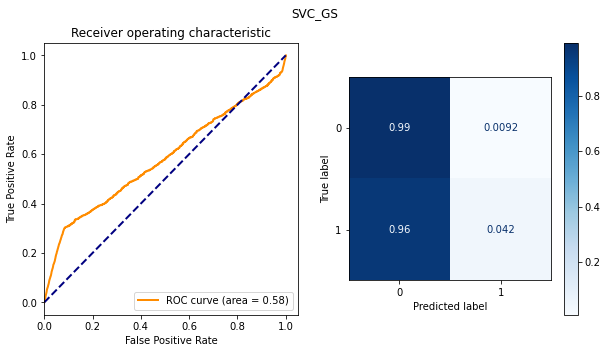

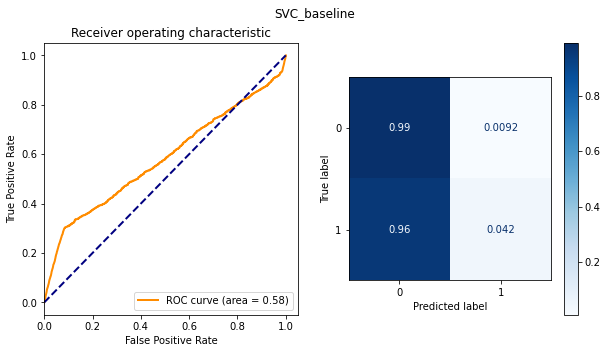

Метод ближайших соседей (Grid Search):
ROC AUC:  0.5791999785409971
Recall:  0.041650447644998055
Balanced Accuracy:  0.5162216181325547

Метод ближайших соседей (Baseline):
ROC AUC:  0.5791999785409971
Recall:  0.041650447644998055
Balanced Accuracy:  0.5162216181325547


In [80]:
# Сравнение baseline модели с найденной лучшей моделью
draw_m(GSCV.best_estimator_, 'SVC_GS', data_test, data_y_test, predict_p[:,1])
draw_m(svc, 'SVC_baseline', data_test, data_y_test, svc.predict_proba(data_test)[:,1])
print('Метод ближайших соседей (Grid Search):')
print('ROC AUC: ', gscv_predicted_rocauc["SVC"])
print('Recall: ', gscv_predicted_recall["SVC"])
print('Balanced Accuracy: ', gscv_predicted_bAccur["SVC"])
print()
print('Метод ближайших соседей (Baseline):')
print('ROC AUC: ', baseline_predicted_rocauc["SVC"])
print('Recall: ', baseline_predicted_recall["SVC"])
print('Balanced Accuracy: ', baseline_predicted_bAccur["SVC"])

### Модель "Решающее дерево":

In [81]:
# Гиперпараметры
n_range = np.array(range(0,3,1))
n_range[0] = 0.1
tuned_parameters = {
    'max_depth': np.array(range(1,62,20)),
    'min_samples_leaf': n_range,
    'max_features': np.array(range(1,10,3))
}

In [82]:
%%time
GSCV = GridSearchCV(DecisionTreeClassifier(random_state=1), tuned_parameters, cv=3, scoring='roc_auc', n_jobs=-1)
GSCV.fit(data_train, data_y_train)

Wall time: 1min 21s


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': array([ 1, 21, 41, 61]),
                         'max_features': array([1, 4, 7]),
                         'min_samples_leaf': array([0, 1, 2])},
             scoring='roc_auc')

In [83]:
# Лучшее значение параметров
GSCV.best_params_

{'max_depth': 21, 'max_features': 7, 'min_samples_leaf': 2}

In [84]:
predict = GSCV.best_estimator_.predict(data_test)
predict_p = GSCV.best_estimator_.predict_proba(data_test)
# Сохранение значений оценок метрик для данной модели
gscv_predicted_rocauc["DT"] = roc_auc_score(data_y_test, predict_p[:,1])
gscv_predicted_recall["DT"] = recall_score(data_y_test, predict)
gscv_predicted_bAccur["DT"] = balanced_accuracy_score(data_y_test, predict)

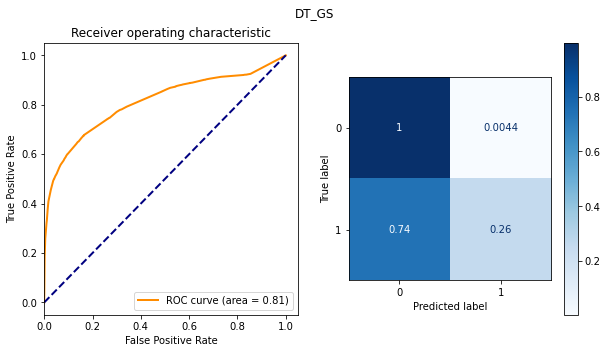

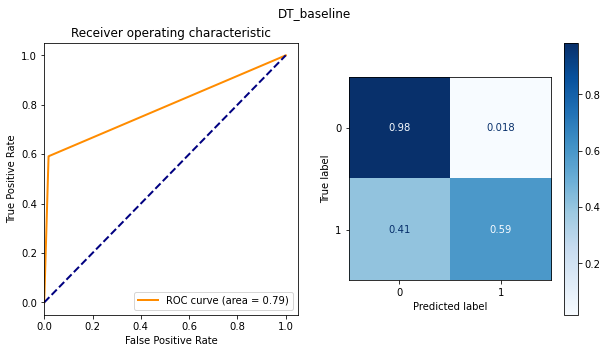

Метод ближайших соседей (Grid Search):
ROC AUC:  0.8104181800356847
Recall:  0.25943947061113276
Balanced Accuracy:  0.6275021447598005

Метод ближайших соседей (Baseline):
ROC AUC:  0.786755931457974
Recall:  0.591475282210977
Balanced Accuracy:  0.7866988543240123


In [85]:
# Сравнение baseline модели с найденной лучшей моделью
draw_m(GSCV.best_estimator_, 'DT_GS', data_test, data_y_test, predict_p[:,1])
draw_m(dtc, 'DT_baseline', data_test, data_y_test, dtc.predict_proba(data_test)[:,1])
print('Метод ближайших соседей (Grid Search):')
print('ROC AUC: ', gscv_predicted_rocauc["DT"])
print('Recall: ', gscv_predicted_recall["DT"])
print('Balanced Accuracy: ', gscv_predicted_bAccur["DT"])
print()
print('Метод ближайших соседей (Baseline):')
print('ROC AUC: ', baseline_predicted_rocauc["DT"])
print('Recall: ', baseline_predicted_recall["DT"])
print('Balanced Accuracy: ', baseline_predicted_bAccur["DT"])

Подбор гиперпараметров улучшил качество модели.

### Модель "Случайный лес":

In [91]:
# Гиперпараметры
tuned_parameters = {
    'n_estimators': np.array(range(50,160,50)),
    'max_features': np.array(range(1,10,3)),
    'min_samples_split': np.array([0.1, 0.4, 0.9]),
    'min_samples_leaf': np.array([0.1, 0.3, 0.5]),
    'max_depth': np.array(range(1,62,20))
}

In [92]:
%%time
GSCV = GridSearchCV(RandomForestClassifier(random_state=1, n_jobs=-1), tuned_parameters, cv=3, scoring='roc_auc')
GSCV.fit(data_train, data_y_train)

Wall time: 59min 5s


GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1, random_state=1),
             param_grid={'max_depth': array([ 1, 21, 41, 61]),
                         'max_features': array([1, 4, 7]),
                         'min_samples_leaf': array([0.1, 0.3, 0.5]),
                         'min_samples_split': array([0.1, 0.4, 0.9]),
                         'n_estimators': array([ 50, 100, 150])},
             scoring='roc_auc')

In [93]:
# Лучшее значение параметров
GSCV.best_params_

{'max_depth': 21,
 'max_features': 7,
 'min_samples_leaf': 0.1,
 'min_samples_split': 0.1,
 'n_estimators': 100}

In [94]:
predict = GSCV.best_estimator_.predict(data_test)
predict_p = GSCV.best_estimator_.predict_proba(data_test)
# Сохранение значений оценок метрик для данной модели
gscv_predicted_rocauc["RF"] = roc_auc_score(data_y_test, predict_p[:,1])
gscv_predicted_recall["RF"] = recall_score(data_y_test, predict)
gscv_predicted_bAccur["RF"] = balanced_accuracy_score(data_y_test, predict)

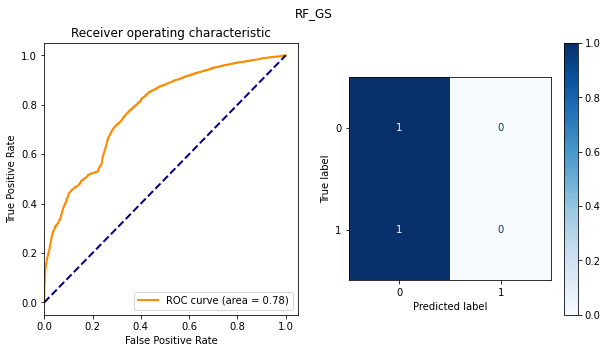

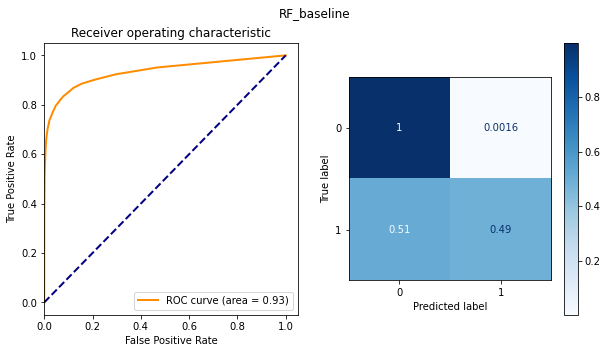

Метод ближайших соседей (Grid Search):
ROC AUC:  0.7789977026634555
Recall:  0.0
Balanced Accuracy:  0.5

Метод ближайших соседей (Baseline):
ROC AUC:  0.9328265098547771
Recall:  0.48871156091864537
Balanced Accuracy:  0.7435662901542637


In [96]:
# Сравнение baseline модели с найденной лучшей моделью
draw_m(GSCV.best_estimator_, 'RF_GS', data_test, data_y_test, predict_p[:,1])
draw_m(RFC, 'RF_baseline', data_test, data_y_test, RFC.predict_proba(data_test)[:,1])
print('Метод ближайших соседей (Grid Search):')
print('ROC AUC: ', gscv_predicted_rocauc["RF"])
print('Recall: ', gscv_predicted_recall["RF"])
print('Balanced Accuracy: ', gscv_predicted_bAccur["RF"])
print()
print('Метод ближайших соседей (Baseline):')
print('ROC AUC: ', baseline_predicted_rocauc["RF"])
print('Recall: ', baseline_predicted_recall["RF"])
print('Balanced Accuracy: ', baseline_predicted_bAccur["RF"])

### Модель "Градиентный бустинг":

In [102]:
# Гиперпараметры
tuned_parameters = {
    'num_leaves': np.array(range(21,45,10)),
    'min_data_in_leaf': np.array(range(0,4,1)),
    'max_depth': np.array(range(-1,62,20)),
    'min_gain_to_split': np.array(range(0,4,1)),
    'min_sum_hessian_in_leaf': np.array(range(0,3,1))
}

In [104]:
%%time
GSCV = GridSearchCV(LGBMClassifier(random_state=1), tuned_parameters, cv=3, scoring='roc_auc', n_jobs=-1)
GSCV.fit(data_train, data_y_train)

In [ ]:
# Лучшее значение параметров
GSCV.best_params_

In [ ]:
predict = GSCV.best_estimator_.predict(data_test)
predict_p = GSCV.best_estimator_.predict_proba(data_test)
# Сохранение значений оценок метрик для данной модели
gscv_predicted_rocauc["LGBM"] = roc_auc_score(data_y_test, predict_p[:,1])
gscv_predicted_recall["LGBM"] = recall_score(data_y_test, predict)
gscv_predicted_bAccur["LGBM"] = balanced_accuracy_score(data_y_test, predict)

In [ ]:
# Сравнение baseline модели с найденной лучшей моделью
draw_m(GSCV.best_estimator_, 'LGBM_GS', data_test, data_y_test, predict_p[:,1])
draw_m(LGBMC, 'LGBM_baseline', data_test, data_y_test, LGBMC.predict_proba(data_test)[:,1])
print('Метод ближайших соседей (Grid Search):')
print('ROC AUC: ', gscv_predicted_rocauc["LGBM"])
print('Recall: ', gscv_predicted_recall["LGBM"])
print('Balanced Accuracy: ', gscv_predicted_bAccur["LGBM"])
print()
print('Метод ближайших соседей (Baseline):')
print('ROC AUC: ', baseline_predicted_rocauc["LGBM"])
print('Recall: ', baseline_predicted_recall["LGBM"])
print('Balanced Accuracy: ', baseline_predicted_bAccur["LGBM"])

## Применение к выбранному набору данных AutoML
### Используем библиотеку [TPOT](https://github.com/EpistasisLab/tpot)

In [97]:
from tpot import TPOTClassifier

D:\ProgramData\Anaconda3\lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [98]:
tpot = TPOTClassifier(random_state=1, n_jobs=-1, scoring='roc_auc', verbosity=2, max_time_mins=30)
tpot.fit(data_train, data_y_train)


32.67 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: DecisionTreeClassifier(SelectPercentile(input_matrix, percentile=96), criterion=entropy, max_depth=6, min_samples_leaf=8, min_samples_split=11)


TPOTClassifier(max_time_mins=30, n_jobs=-1, random_state=1, scoring='roc_auc',
               verbosity=2)

In [99]:
# Информация о лучшей модели
tpot.fitted_pipeline_

Pipeline(steps=[('selectpercentile', SelectPercentile(percentile=96)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(criterion='entropy', max_depth=6,
                                        min_samples_leaf=8,
                                        min_samples_split=11,
                                        random_state=1))])

In [100]:
predict = tpot.predict(data_test)
predict_p = tpot.predict_proba(data_test)
tpot_predicted_rocauc = roc_auc_score(data_y_test, predict_p[:,1])
tpot_predicted_recall = recall_score(data_y_test, predict)
tpot_predicted_bAccur = balanced_accuracy_score(data_y_test, predict)

Оценки AutoML (TPOT) модели:
ROC AUC:  0.8371889866779217
Recall:  0.21564811210587778
Balanced Accuracy:  0.6066871900136539


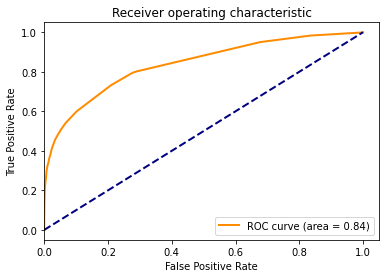

In [101]:
print('Оценки AutoML (TPOT) модели:')
print('ROC AUC: ', tpot_predicted_rocauc)
print('Recall: ', tpot_predicted_recall)
print('Balanced Accuracy: ', tpot_predicted_bAccur)
fig, ax = plt.subplots() 
draw_roc_curve(data_y_test, predict_p[:,1], ax)
plt.show()

## Формирование выводов о качестве построенных моделей на основе выбранных метрик

In [105]:
# Визуализация качества моделей
def vis_models_quality(dit1, dit2, dit3, str_headers, nm, figsize=(10, 5)):
    dt1 = dict(sorted(dit1.items(), key=lambda x: x[1]))
    fig, ax = plt.subplots(ncols=3, figsize=figsize)
    pos = np.arange(len(dt1))
    rects = ax[0].barh(pos, dt1.values(),
                     align='center',
                     height=0.5, 
                     tick_label=list(dt1.keys()))
    ax[0].set_title(str_headers[0])
    for a,b in zip(pos, dt1.values()):
        ax[0].text(0.2, a-0.1, str(round(b,3)), color='white')
    
    dt2 = dict(sorted(dit2.items(), key=lambda x: x[1]))
    pos = np.arange(len(dt2))
    rects = ax[1].barh(pos, dt2.values(),
                     align='center',
                     height=0.5, 
                     tick_label=list(dt2.keys()))
    ax[1].set_title(str_headers[1])
    for a,b in zip(pos, dt2.values()):
        ax[1].text(0.2, a-0.1, str(round(b,3)), color='white')
    
    dt3 = dict(sorted(dit3.items(), key=lambda x: x[1]))
    pos = np.arange(len(dt3))
    rects = ax[2].barh(pos, dt3.values(),
                     align='center',
                     height=0.5, 
                     tick_label=list(dt3.keys()))
    ax[2].set_title(str_headers[2])
    for a,b in zip(pos, dt3.values()):
        ax[2].text(0.2, a-0.1, str(round(b,3)), color='white')
    fig.suptitle(nm)
    plt.show()

In [106]:
print('Оценки AutoML (TPOT) модели:')
print('ROC AUC: ', tpot_predicted_rocauc)
print('Recall: ', tpot_predicted_recall)
print('Balanced Accuracy: ', tpot_predicted_bAccur)

Оценки AutoML (TPOT) модели:
ROC AUC:  0.8371889866779217
Recall:  0.21564811210587778
Balanced Accuracy:  0.6066871900136539


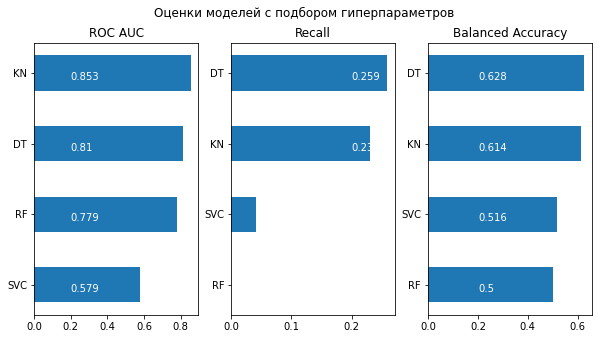

In [107]:
vis_models_quality(gscv_predicted_rocauc, gscv_predicted_recall, gscv_predicted_bAccur, ['ROC AUC', 'Recall', 'Balanced Accuracy'], 'Оценки моделей с подбором гиперпараметров')

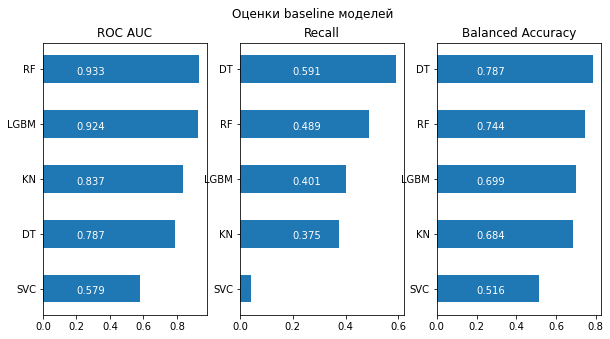

In [108]:
vis_models_quality(baseline_predicted_rocauc, baseline_predicted_recall, baseline_predicted_bAccur, ['ROC AUC', 'Recall', 'Balanced Accuracy'], 'Оценки baseline моделей')

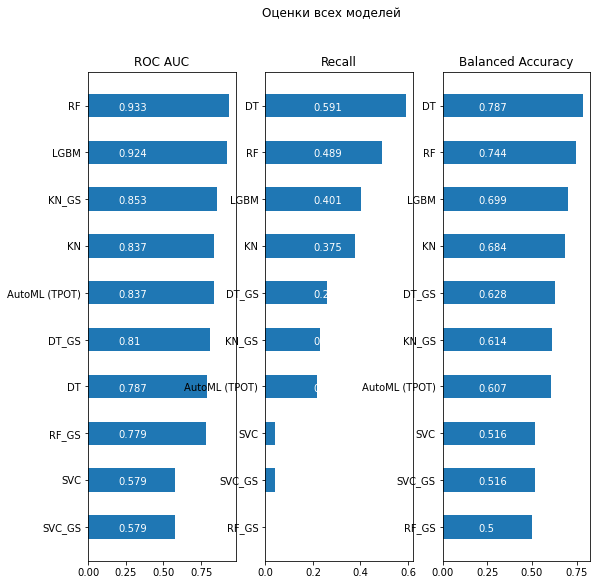

In [109]:
ra_all = {'AutoML (TPOT)':tpot_predicted_rocauc}
for i in gscv_predicted_rocauc:
    ra_all[i+'_GS'] = gscv_predicted_rocauc[i]
for i in baseline_predicted_rocauc:
    ra_all[i] = baseline_predicted_rocauc[i]

re_all = {'AutoML (TPOT)':tpot_predicted_recall}
for i in gscv_predicted_recall:
    re_all[i+'_GS'] = gscv_predicted_recall[i]
for i in baseline_predicted_recall:
    re_all[i] = baseline_predicted_recall[i]

ba_all = {'AutoML (TPOT)':tpot_predicted_bAccur}
for i in gscv_predicted_bAccur:
    ba_all[i+'_GS'] = gscv_predicted_bAccur[i]
for i in baseline_predicted_bAccur:
    ba_all[i] = baseline_predicted_bAccur[i]
    
vis_models_quality(ra_all, re_all, ba_all, ['ROC AUC', 'Recall', 'Balanced Accuracy'], 'Оценки всех моделей', figsize=(9, 9))

**Вывод.** На основании трех метрик, лучшей моделью оказалась **"Случайный лес"**. В отдельных случаях наиболее подходящей моделью является **"Дерево решений"**.